# 导入库

In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go 
import plotly.tools as tls
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

train_data_src = pd.read_csv('data/jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test_data_src  = pd.read_csv('data/jinnan_round1_testA_20181227.csv', encoding = 'gb18030')
print(train_data_src.loc[1304, 'A25'])
train_data_src.loc[1304, 'A25'] = np.nan
print(train_data_src.loc[1304, 'A25'])


1900/3/10 0:00
nan


In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

# 数据预处理

In [3]:
train_data_src = pd.read_csv('data/jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test_data_src  = pd.read_csv('data/jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [4]:
# print(train_data_src[0:5][:])
print(train_data_src.shape)
print(test_data_src.shape)
print(train_data_src.loc[1304, 'A25'])
train_data_src.loc[1304, 'A25'] = -1
print(train_data_src.loc[1304, 'A25'])


(1396, 44)
(150, 43)
1900/3/10 0:00
-1


In [5]:
stats = []
for col in train_data_src.columns:
    stats.append((col,
                  train_data_src[col].nunique(),
                  train_data_src[col].isnull().sum() * 100 / train_data_src.shape[0],
                  train_data_src[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  train_data_src[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature',
                                        'Unique_values',
                                        'Percentage of missing values',
                                        'Percentage of values in the biggest category',
                                        'type'])

stats_df.sort_values('Percentage of missing values', ascending=False)[:]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [6]:
stats = []
for col in test_data_src.columns:
    stats.append((col,
                  test_data_src[col].nunique(),
                  test_data_src[col].isnull().sum() * 100 / test_data_src.shape[0],
                  test_data_src[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  test_data_src[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature',
                                        'Unique_values',
                                        'Percentage of missing values',
                                        'Percentage of values in the biggest category',
                                        'type'])

stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


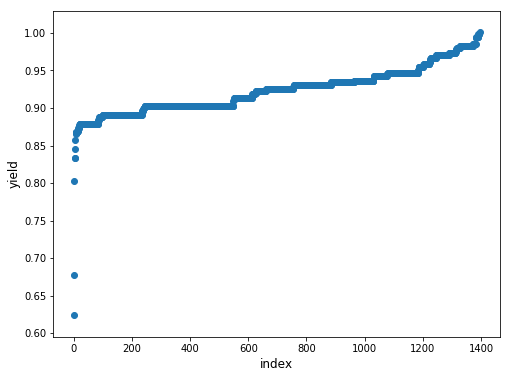

In [7]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train_data_src.shape[0]), np.sort(train_data_src[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

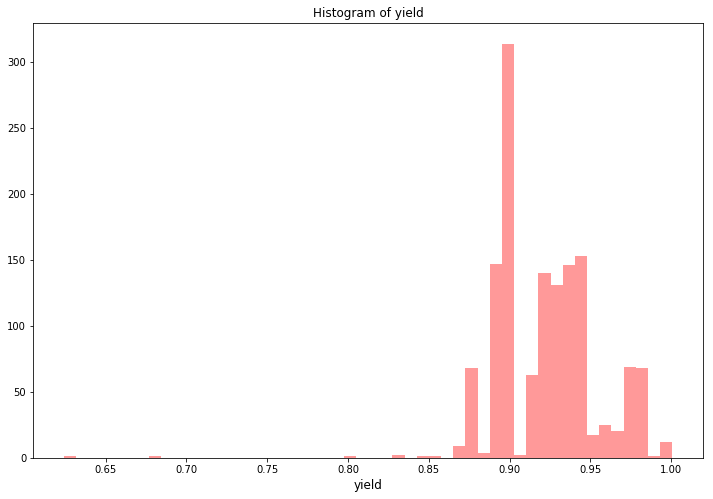

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train_data_src[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

# 特征工程

## 剔除类别单一数据

In [9]:
train = train_data_src.copy()
test = test_data_src.copy()
print(train.shape)
print(test.shape)
print(train[0:5][:])

(1396, 44)
(150, 43)
          样本id   A1  A2     A3   A4        A5    A6   A7  A8        A9  A10  \
0  sample_1528  300 NaN  405.0  700  13:30:00  38.0  NaN NaN  15:30:00  100   
1  sample_1698  300 NaN  405.0  700  14:00:00  29.0  NaN NaN  16:00:00  101   
2   sample_639  300 NaN  405.0  700  14:00:00  29.0  NaN NaN  16:00:00  102   
3   sample_483  300 NaN  405.0  700   1:30:00  38.0  NaN NaN   3:00:00  100   
4   sample_617  300 NaN  405.0  700  22:00:00  29.0  NaN NaN   0:00:00  101   

        A11  A12  A13       A14    A15       A16    A17  A18  A19  \
0  16:30:00  102  0.2  17:30:00  103.0  18:30:00  104.0  0.2  300   
1  17:00:00  103  0.2  18:00:00  104.0  19:00:00  105.0  0.2  200   
2  17:00:00  103  0.2  18:00:00  104.0  19:00:00  105.0  0.2  200   
3   4:00:00  102  0.2   5:00:00  103.0   6:00:00  104.0  0.2  200   
4   1:00:00  103  0.2   2:00:00  104.0   3:00:00  105.0  0.2  200   

           A20   A21   A22  A23       A24 A25       A26  A27          A28  \
0  21:00-21:

In [10]:
good_cols = list(train.columns)
for col in train.columns:
    
    # 删除丢失超过 60% 的列
    rate = train[col].isnull().sum() / train.shape[0]
    if rate > 0.6:
        good_cols.remove(col)
        print("The percentage of missing values of {} is {} that more than 60%".format(col, rate))
        continue
        
    # 删除最大类别占比超过90%的列
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print("The maximum category percentage of {} is {} that more than 90%".format(col, rate))

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

The maximum category percentage of A1 is 0.9863896848137536 that more than 90%
The percentage of missing values of A2 is 0.9699140401146131 that more than 60%
The maximum category percentage of A3 is 0.9570200573065902 that more than 90%
The maximum category percentage of A4 is 0.9570200573065902 that more than 90%
The percentage of missing values of A7 is 0.8932664756446992 that more than 60%
The percentage of missing values of A8 is 0.8932664756446992 that more than 60%
The maximum category percentage of A13 is 0.998567335243553 that more than 90%
The maximum category percentage of A18 is 0.9992836676217765 that more than 90%
The maximum category percentage of A23 is 0.9964183381088825 that more than 90%
The maximum category percentage of B2 is 0.9842406876790831 that more than 90%
The maximum category percentage of B3 is 0.9978510028653295 that more than 90%
The percentage of missing values of B11 is 0.6081661891117478 that more than 60%
The maximum category percentage of B13 is 0.9

(1381, 31)


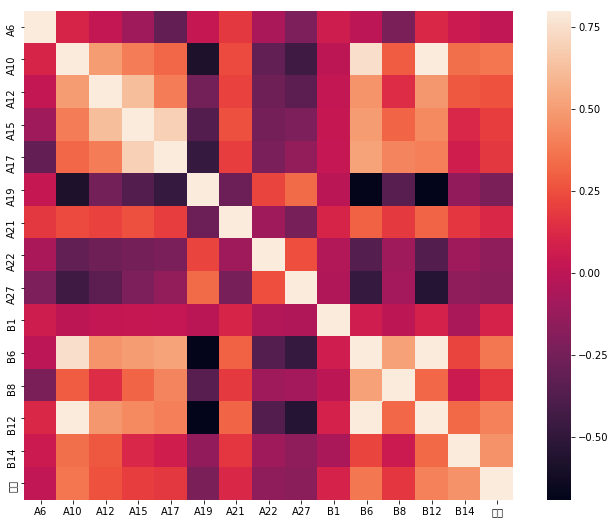

In [11]:
# print(train[1:3])
# print(train[1:3][[idx for idx in train.columns if idx != target_col]])
print(train.shape)
def heatmap(pd_data):
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True)
    
heatmap(train)

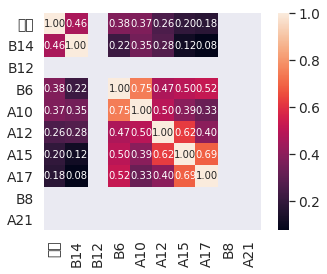

In [12]:
def heatmap_font(pd_data, k=10, target='收率'):
    # k is the number of variables for heatmap
    corrmat = pd_data.corr()
    cols = corrmat.nlargest(k, target)[target].index
    cm = np.corrcoef(pd_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
    yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
    
heatmap_font(train)

## 合并训练集和测试集，填充 NAN 为 -1

In [13]:
# 合并数据集
target = train['收率']
# del train['收率']
data = pd.concat([train[:][[idx for idx in train.columns if idx != target_col]],test],
                 axis=0,
                 ignore_index=True)
data = data.fillna(-1)
print(data[0:5][:])

          样本id        A5    A6        A9  A10       A11    A12       A14  \
0  sample_1528  13:30:00  38.0  15:30:00  100  16:30:00  102.0  17:30:00   
1  sample_1698  14:00:00  29.0  16:00:00  101  17:00:00  103.0  18:00:00   
2   sample_639  14:00:00  29.0  16:00:00  102  17:00:00  103.0  18:00:00   
3   sample_483   1:30:00  38.0   3:00:00  100   4:00:00  102.0   5:00:00   
4   sample_617  22:00:00  29.0   0:00:00  101   1:00:00  103.0   2:00:00   

     A15       A16    A17  A19          A20   A21   A22       A24 A25  \
0  103.0  18:30:00  104.0  300  21:00-21:30  50.0   9.0  22:00:00  75   
1  104.0  19:00:00  105.0  200  19:00-20:00  50.0   9.0  20:00:00  80   
2  104.0  19:00:00  105.0  200  19:00-19:30  50.0   9.0  20:00:00  79   
3  103.0   6:00:00  104.0  200    6:30-7:00  50.0  10.0   7:30:00  70   
4  104.0   3:00:00  105.0  200    3:00-4:00  50.0   9.0   4:00:00  80   

        A26   A27          A28     B1           B4        B5  B6        B7  \
0  22:30:00  70.0    6:30-

## 处理时间特征

In [14]:
def timeTranSecond(t):
    try:
        h,m,s=t.split(":")
    except:
#         if t == -1:
#             return -1
#         print(t)

        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(h)*3600+int(m)*60+int(s))/3600
    except:
#         print("h, m, s = {}, {}, {}".format(h, m, s))
        return (30*60)/3600
    
    return tm

In [15]:
# timeTranSecond('13:30:00')
# print('1900/1/21 0:00'.split(":"))
print(type(data))
print(data.shape)
print(data.loc[1289, 'A25'])

<class 'pandas.core.frame.DataFrame'>
(1531, 30)
-1


In [16]:
# 'A7'
for f in ['A5','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(timeTranSecond)

# data[1285:1290]
# print(data[1285:1230]['A16'])

In [17]:
def getDuration(se):
    try:
#         print(se)
        sh,sm,eh,em=re.findall(r"\d+",se)
#         print("sh, sm, eh, em = {}, {}, {}, {}".format(sh, em, eh, em))
    except:
        if se == -1:
            return -1 
        
        print(se)
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm

In [18]:
getDuration('6:30-7:00')

0.5

In [19]:
# 'B11'
for f in ['A20','A28','B4','B9','B10']:
    data[f] = data[f].apply(getDuration)
#     data.apply(lambda df: getDuration(df[f]), axis=1)

15:00-1600
19:-20:05


## 生成最终训练集和测试集

In [20]:
cate_columns = [f for f in data.columns if f != '样本id']

In [21]:
# print(data[0:2])

In [22]:
#label encoder
print(data.shape)
data_map = data.copy()
for f in cate_columns:
#     print("data[{}] = \n{}".format(f, data[0:2][f]))
    data_map[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
#     print("data_map[{}] = \n{}".format(f, data_map[0:2][f]))

(1531, 30)


In [23]:
# debug
# print(data['A7'].unique())
# print(data['A7'].nunique())
# print(range(0, data['A5'].nunique()))
# zip(data['A5'].unique())

In [24]:
# debug
# temp = train_final[:10]
# print(temp.shape)
# print(temp['A5'].unique())
# print(range(0, temp['A5'].nunique()))
# print(temp)
# temp['cut'] = pd.cut(temp, 6, labels=False)
# print(temp['cut'])
# print(temp.shape)

## 添加新特征，将收率进行分箱，然后构造每个特征中的类别对应不同收率的均值

In [25]:
def add_feature(train_final, test_final):
    train_final['intTarget'] = pd.cut(train_final['target'], 5, labels=False)
    train_final = pd.get_dummies(train_final, columns=['intTarget'])
    # print("train_final = \n{}".format(train_final[0:2]))
    li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
    mean_features = []

    for f1 in cate_columns:
        for f2 in li:
            col_name = f1+"_"+f2+'_mean'
            mean_features.append(col_name)
            order_label = train_final.groupby([f1])[f2].mean()
    #         print("f1 = {}, f2 = {}, order_label = \n{}".format(f1, f2, order_label))
            for df in [train_final, test_final]:
#                 df[col_name] = df[f].map(order_label) # 正是此处逻辑错误
                df[col_name] = df[f1].map(order_label)

    train_final.drop(li, axis=1, inplace=True)

    print("After adding feature:")
    print(train_final.shape)
    print(test_final.shape)
    return (train_final, test_final)

train_final = data_map[:train.shape[0]]
test_final  = data_map[train.shape[0]:]
train_final['target'] = target
print(train_final.shape)
print(test_final.shape)
(train_final, test_final) = add_feature(train_final, test_final)
train_final[0:2]

(1381, 31)
(150, 30)
After adding feature:
(1381, 176)
(150, 175)


,样本id,A5,A6,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B12,B14,target,A5_intTarget_0.0_mean,A5_intTarget_1.0_mean,A5_intTarget_2.0_mean,A5_intTarget_3.0_mean,A5_intTarget_4.0_mean,A6_intTarget_0.0_mean,A6_intTarget_1.0_mean,A6_intTarget_2.0_mean,A6_intTarget_3.0_mean,A6_intTarget_4.0_mean,A9_intTarget_0.0_mean,A9_intTarget_1.0_mean,A9_intTarget_2.0_mean,A9_intTarget_3.0_mean,A9_intTarget_4.0_mean,A10_intTarget_0.0_mean,A10_intTarget_1.0_mean,A10_intTarget_2.0_mean,A10_intTarget_3.0_mean,A10_intTarget_4.0_mean,A11_intTarget_0.0_mean,A11_intTarget_1.0_mean,A11_intTarget_2.0_mean,A11_intTarget_3.0_mean,A11_intTarget_4.0_mean,A12_intTarget_0.0_mean,A12_intTarget_1.0_mean,A12_intTarget_2.0_mean,A12_intTarget_3.0_mean,A12_intTarget_4.0_mean,A14_intTarget_0.0_mean,A14_intTarget_1.0_mean,A14_intTarget_2.0_mean,A14_intTarget_3.0_mean,A14_intTarget_4.0_mean,A15_intTarget_0.0_mean,A15_intTarget_1.0_mean,A15_intTarget_2.0_mean,A15_intTarget_3.0_mean,A15_intTarget_4.0_mean,A16_intTarget_0.0_mean,A16_intTarget_1.0_mean,A16_intTarget_2.0_mean,A16_intTarget_3.0_mean,A16_intTarget_4.0_mean,A17_intTarget_0.0_mean,A17_intTarget_1.0_mean,A17_intTarget_2.0_mean,A17_intTarget_3.0_mean,A17_intTarget_4.0_mean,A19_intTarget_0.0_mean,A19_intTarget_1.0_mean,A19_intTarget_2.0_mean,A19_intTarget_3.0_mean,A19_intTarget_4.0_mean,A20_intTarget_0.0_mean,A20_intTarget_1.0_mean,A20_intTarget_2.0_mean,A20_intTarget_3.0_mean,A20_intTarget_4.0_mean,A21_intTarget_0.0_mean,A21_intTarget_1.0_mean,A21_intTarget_2.0_mean,A21_intTarget_3.0_mean,A21_intTarget_4.0_mean,A22_intTarget_0.0_mean,A22_intTarget_1.0_mean,A22_intTarget_2.0_mean,A22_intTarget_3.0_mean,A22_intTarget_4.0_mean,A24_intTarget_0.0_mean,A24_intTarget_1.0_mean,A24_intTarget_2.0_mean,A24_intTarget_3.0_mean,A24_intTarget_4.0_mean,A25_intTarget_0.0_mean,A25_intTarget_1.0_mean,A25_intTarget_2.0_mean,A25_intTarget_3.0_mean,A25_intTarget_4.0_mean,A26_intTarget_0.0_mean,A26_intTarget_1.0_mean,A26_intTarget_2.0_mean,A26_intTarget_3.0_mean,A26_intTarget_4.0_mean,A27_intTarget_0.0_mean,A27_intTarget_1.0_mean,A27_intTarget_2.0_mean,A27_intTarget_3.0_mean,A27_intTarget_4.0_mean,A28_intTarget_0.0_mean,A28_intTarget_1.0_mean,A28_intTarget_2.0_mean,A28_intTarget_3.0_mean,A28_intTarget_4.0_mean,B1_intTarget_0.0_mean,B1_intTarget_1.0_mean,B1_intTarget_2.0_mean,B1_intTarget_3.0_mean,B1_intTarget_4.0_mean,B4_intTarget_0.0_mean,B4_intTarget_1.0_mean,B4_intTarget_2.0_mean,B4_intTarget_3.0_mean,B4_intTarget_4.0_mean,B5_intTarget_0.0_mean,B5_intTarget_1.0_mean,B5_intTarget_2.0_mean,B5_intTarget_3.0_mean,B5_intTarget_4.0_mean,B6_intTarget_0.0_mean,B6_intTarget_1.0_mean,B6_intTarget_2.0_mean,B6_intTarget_3.0_mean,B6_intTarget_4.0_mean,B7_intTarget_0.0_mean,B7_intTarget_1.0_mean,B7_intTarget_2.0_mean,B7_intTarget_3.0_mean,B7_intTarget_4.0_mean,B8_intTarget_0.0_mean,B8_intTarget_1.0_mean,B8_intTarget_2.0_mean,B8_intTarget_3.0_mean,B8_intTarget_4.0_mean,B9_intTarget_0.0_mean,B9_intTarget_1.0_mean,B9_intTarget_2.0_mean,B9_intTarget_3.0_mean,B9_intTarget_4.0_mean,B10_intTarget_0.0_mean,B10_intTarget_1.0_mean,B10_intTarget_2.0_mean,B10_intTarget_3.0_mean,B10_intTarget_4.0_mean,B12_intTarget_0.0_mean,B12_intTarget_1.0_mean,B12_intTarget_2.0_mean,B12_intTarget_3.0_mean,B12_intTarget_4.0_mean,B14_intTarget_0.0_mean,B14_intTarget_1.0_mean,B14_intTarget_2.0_mean,B14_intTarget_3.0_mean,B14_intTarget_4.0_mean
0,sample_1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.879,0.285714,0.285714,0.428571,0.000000,0.000000,0.157895,0.210526,0.438596,0.105263,0.070175,0.058824,0.470588,0.235294,0.117647,0.117647,0.177743,0.272025,0.387944,0.092736,0.052550,0.058824,0.470588,0.235294,0.117647,0.117647,0.177500,0.26500,0.39250,0.095000,0.057500,0.055556,0.500000,0.222222,0.111111,0.111111,0.179402,0.275748,0.388704,0.079734,0.053156,0.058824,0.470588,0.235294,0.117647,0.117647,0.195402,0.258621,0.425287,0.074713,0.028736,0.147903,0.275938,0.412804,0.092715,0.055188,0.171815,0.281853,0.38610

In [26]:
# print(train_final[0:2].values)
# heatmap(train_final)
# heatmap_font(train_final, k=10, target='target')

In [27]:
train_final.drop(['样本id','target'], axis=1, inplace=True)
test_final = test_final[train_final.columns]
train = train_final
test = test_final
X_train = train_final.values
y_train = target.values
X_test = test_final.values

In [40]:
print("X_train : {}".format(np.shape(X_train)))
print("y_train : {}".format(np.shape(y_train)))
print("X_test : {}".format(np.shape(X_test)))

# data_map

# check string
# for x_y in [X_train, X_test]:
#     print("(rows, columns) = {}, {}".format(x_y.shape[0], x_y.shape[1]))    
#     for i in range(x_y.shape[0]):
#         for j in range(x_y.shape[1]):
#             if isinstance(x_y[i][j], str):
#                 print("(i, j) = {}, {}".format(i, j))
#                 print(x_y[i][j])
#                 print(type(x_y[i][j]))
X_train.shape, y_train.shape, X_test.shape, X_train.dtype, y_train.dtype, X_test.dtype

X_train : (1381, 174)
y_train : (1381,)
X_test : (150, 174)


((1381, 174),
 (1381,),
 (150, 174),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

# 训练模型

## 多模型测试

In [29]:
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
    return mse

In [30]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [31]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = mse_cv(model, X_train, y_train)
    print("{}: {:.6f}, {:.4f}".format(name, score.mean(), score.std()))

LR: 83468873788484432.000000, 166060059667623456.0000
Ridge: 0.000570, 0.0000
Lasso: 0.000682, 0.0001
RF: 0.000210, 0.0000
GBR: 0.000206, 0.0000
SVR: 0.000942, 0.0000
LinSVR: 0.005119, 0.0024
Ela: 0.000640, 0.0000
SGD: 4097200416416436685111296.000000, 3223219804832739895541760.0000
Bay: 0.000613, 0.0000
Ker: 0.000695, 0.0001
Extra: 0.000209, 0.0000
Xgb: 0.000191, 0.0000


## lgb

In [32]:
def lgb_train(trn_data, val_data, oof_lgb_val, predictions_lgb):
    param = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.1,
             "verbosity": -1}

#     folds = KFold(n_splits=5, shuffle=True, random_state=2018)
#     oof_lgb = np.zeros(len(train))
#     predictions_lgb = np.zeros(len(test))


#     for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
#         print("fold n°{}".format(fold_+1))
#         trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
#         val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds = 100)

    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    oof_lgb_val = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)

#     predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

#     print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

In [33]:
# print(np.shape(X_train[trn_idx]))
# print(type(X_train[trn_idx]))
# print(X_train[1289:1290])
# print(y_train[1289:1290])

# for i in range(X_train.shape[1]):
#     if isinstance(X_train[1289][i], str):
#         print("i = {}".format(i))
        
# trn_data = lgb.Dataset(X_train[0:2090], y_train[0:2090])
# val_data = lgb.Dataset(X_train[range(10)], y_train[range(10)])
# lgb_train(trn_data, val_data, [], [])

In [46]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

trn_idx = range(0, 1000)
val_idx = range(1000, 1300)
trn_data = lgb.Dataset(np.array([[1], [2], [3]]), np.array([1, 2, 3]))
val_data = lgb.Dataset(np.array([[1], [2], [3]]), np.array([1, 2, 3]))

print(type(trn_data))

num_round = 10000
clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
# oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)


<class 'lightgbm.basic.Dataset'>
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's l2: 4.66667	valid_1's l2: 4.66667


In [34]:
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])
    
    lgb_train(trn_data, val_data, oof_lgb[val_idx], predictions_lgb)
    
    print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))
    

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000223755	valid_1's l2: 0.000247596
[400]	training's l2: 0.000165712	valid_1's l2: 0.000209535
[600]	training's l2: 0.000140607	valid_1's l2: 0.000199498
[800]	training's l2: 0.00012747	valid_1's l2: 0.000196111
[1000]	training's l2: 0.000119064	valid_1's l2: 0.000194376
[1200]	training's l2: 0.000113134	valid_1's l2: 0.000193718
[1400]	training's l2: 0.000108633	valid_1's l2: 0.00019359
Early stopping, best iteration is:
[1323]	training's l2: 0.000110314	valid_1's l2: 0.000193357
CV score: 0.68336417
fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000219013	valid_1's l2: 0.000247799
[400]	training's l2: 0.000158077	valid_1's l2: 0.000224164
[600]	training's l2: 0.000134814	valid_1's l2: 0.000218122
[800]	training's l2: 0.000121754	valid_1's l2: 0.000214864
Early stopping, best iteration is:
[870]	training's l2: 0.000118603	valid_1's l2: 0.000214

## xgb

In [35]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx]*1000)
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx]*1000)

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)/1000
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:919.43	valid_data-rmse:920.292
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:557.714	valid_data-rmse:558.591
[200]	train-rmse:338.693	valid_data-rmse:339.636
[300]	train-rmse:206.103	valid_data-rmse:207.141
[400]	train-rmse:125.844	valid_data-rmse:126.709
[500]	train-rmse:77.4316	valid_data-rmse:78.1355
[600]	train-rmse:48.4311	valid_data-rmse:49.1506
[700]	train-rmse:31.1361	valid_data-rmse:32.2069
[800]	train-rmse:20.9712	valid_data-rmse:22.7667
[900]	train-rmse:15.029	valid_data-rmse:17.7751
[1000]	train-rmse:11.6402	valid_data-rmse:15.309
[1100]	train-rmse:9.73735	valid_data-rmse:14.1505
[1200]	train-rmse:8.65759	valid_data-rmse:13.6159
[1300]	train-rmse:7.98867	valid_data-rmse:13.393
[1400]	train-rmse:7.58138	valid_data-rmse:13.2884
[1500]	train-rmse:7.28758	valid_data-rmse:13.2614
[1600]	train-rmse:7.06586	valid_data-rmse:13.2576
[

In [36]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00018219404468670995

## nn

In [37]:
import keras
from keras.models import Model
from keras.models import Sequential 
from keras.layers import Dense, Input, add
from keras.layers.core import Dropout, Activation

def dense_block(inp, drop_rate = 0.5):
    x = Dense(100,activation='sigmoid')(inp)
    x = Dropout(drop_rate)(x)
    x = Dense(100,activation='sigmoid')(inp)
    x = Dropout(drop_rate)(x)
    x = Dense(100,activation='sigmoid')(inp)
    x = Dropout(drop_rate)(x)
    x = add([x, inp])

    return x

# model = Sequential()

# model.add(Dense(100, input_shape=(X_train.shape[1],))) # 输入层，26
# model.add(Activation('sigmoid')) # 激活函数是tanh  
# # model.add(Dropout(0.5)) # 采用50%的dropout

# model.add(Dense(100)) # 隐藏层节点500个  
# model.add(Activation('sigmoid'))  
# # model.add(Dropout(0.5))


# model.add(Dense(1)) # 输出结果是10个类别，所以维度是10  

# model.compile(loss='mse', optimizer='adam')
# model.summary()

inpt = Input(shape=(X_train.shape[1],))
x = Dense(100,activation='sigmoid')(inpt)
x = dense_block(x, drop_rate=0.5)
# x = dense_block(x, drop_rate=0.9)
# x = dense_block(x, drop_rate=0.9)
x = Dense(1)(x)

model = Model(inputs=inpt,outputs=x)
model.compile(loss='mse', optimizer='adam')
model.summary()

'''
   .fit的一些参数
   batch_size：对总的样本数进行分组，每组包含的样本数量
   epochs ：训练次数
   shuffle：是否把数据随机打乱之后再进行训练
   validation_split：拿出百分之多少用来做交叉验证
   verbose：屏显模式 0：不输出  1：输出进度  2：输出每次的训练结果
'''
print('Training -----------')
model.fit(X_train[:1000],
          y_train[:1000],
          batch_size=200,
          epochs=5000,
          shuffle=True,
          verbose=1,
          validation_split=0.3)
    
print("test set")
scores = model.evaluate(X_train[1000:], y_train[1000:], batch_size=200, verbose=1)
print("")
print("The test loss is %f" % scores)
# Y_pred = model.predict(X_train[1000:])
# plt.scatter(range(), y_train[1000:])
# plt.plot(X_train[1000:], Y_pred)
# plt.show()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 174)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          17500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 100)          0           dense_4[0][0]                    
__________________________________________________________________________________________________
add_1 (Add

700/700 [==============================] - 0s 15us/step - loss: 0.0091 - val_loss: 0.0069
Epoch 63/5000
700/700 [==============================] - 0s 14us/step - loss: 0.0085 - val_loss: 0.0068
Epoch 64/5000
700/700 [==============================] - 0s 15us/step - loss: 0.0083 - val_loss: 0.0067
Epoch 65/5000
700/700 [==============================] - 0s 14us/step - loss: 0.0079 - val_loss: 0.0068
Epoch 66/5000
700/700 [==============================] - 0s 13us/step - loss: 0.0081 - val_loss: 0.0067
Epoch 67/5000
700/700 [==============================] - 0s 16us/step - loss: 0.0079 - val_loss: 0.0066
Epoch 68/5000
700/700 [==============================] - 0s 14us/step - loss: 0.0073 - val_loss: 0.0066
Epoch 69/5000
700/700 [==============================] - 0s 13us/step - loss: 0.0070 - val_loss: 0.0066
Epoch 70/5000
700/700 [==============================] - 0s 16us/step - loss: 0.0071 - val_loss: 0.0066
Epoch 71/5000
700/700 [==============================] - 0s 15us/step - loss: 

700/700 [==============================] - 0s 13us/step - loss: 0.0026 - val_loss: 0.0047
Epoch 141/5000
700/700 [==============================] - 0s 22us/step - loss: 0.0024 - val_loss: 0.0047
Epoch 142/5000
700/700 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0047
Epoch 143/5000
700/700 [==============================] - 0s 13us/step - loss: 0.0023 - val_loss: 0.0048
Epoch 144/5000
700/700 [==============================] - 0s 15us/step - loss: 0.0023 - val_loss: 0.0048
Epoch 145/5000
700/700 [==============================] - 0s 15us/step - loss: 0.0022 - val_loss: 0.0047
Epoch 146/5000
700/700 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0047
Epoch 147/5000
700/700 [==============================] - 0s 14us/step - loss: 0.0023 - val_loss: 0.0047
Epoch 148/5000
700/700 [==============================] - 0s 14us/step - loss: 0.0020 - val_loss: 0.0047
Epoch 149/5000
700/700 [==============================] - 0s 13us/step

700/700 [==============================] - 0s 13us/step - loss: 0.0012 - val_loss: 0.0041
Epoch 219/5000
700/700 [==============================] - 0s 15us/step - loss: 0.0012 - val_loss: 0.0041
Epoch 220/5000
700/700 [==============================] - 0s 19us/step - loss: 0.0011 - val_loss: 0.0040
Epoch 221/5000
700/700 [==============================] - 0s 15us/step - loss: 0.0012 - val_loss: 0.0041
Epoch 222/5000
700/700 [==============================] - 0s 15us/step - loss: 0.0012 - val_loss: 0.0040
Epoch 223/5000
700/700 [==============================] - 0s 17us/step - loss: 0.0012 - val_loss: 0.0041
Epoch 224/5000
700/700 [==============================] - 0s 16us/step - loss: 0.0012 - val_loss: 0.0040
Epoch 225/5000
700/700 [==============================] - 0s 13us/step - loss: 0.0011 - val_loss: 0.0040
Epoch 226/5000
700/700 [==============================] - 0s 17us/step - loss: 0.0011 - val_loss: 0.0040
Epoch 227/5000
700/700 [==============================] - 0s 15us/step

700/700 [==============================] - 0s 13us/step - loss: 7.5495e-04 - val_loss: 0.0039
Epoch 295/5000
700/700 [==============================] - 0s 13us/step - loss: 7.6903e-04 - val_loss: 0.0039
Epoch 296/5000
700/700 [==============================] - 0s 14us/step - loss: 8.5552e-04 - val_loss: 0.0038
Epoch 297/5000
700/700 [==============================] - 0s 14us/step - loss: 7.6559e-04 - val_loss: 0.0039
Epoch 298/5000
700/700 [==============================] - 0s 15us/step - loss: 7.3743e-04 - val_loss: 0.0039
Epoch 299/5000
700/700 [==============================] - 0s 17us/step - loss: 7.6205e-04 - val_loss: 0.0039
Epoch 300/5000
700/700 [==============================] - 0s 14us/step - loss: 7.6271e-04 - val_loss: 0.0038
Epoch 301/5000
700/700 [==============================] - 0s 16us/step - loss: 7.1479e-04 - val_loss: 0.0039
Epoch 302/5000
700/700 [==============================] - 0s 16us/step - loss: 8.5016e-04 - val_loss: 0.0038
Epoch 303/5000
700/700 [==========

700/700 [==============================] - 0s 13us/step - loss: 5.5961e-04 - val_loss: 0.0037
Epoch 370/5000
700/700 [==============================] - 0s 15us/step - loss: 5.7757e-04 - val_loss: 0.0038
Epoch 371/5000
700/700 [==============================] - 0s 17us/step - loss: 5.5682e-04 - val_loss: 0.0037
Epoch 372/5000
700/700 [==============================] - 0s 13us/step - loss: 5.8881e-04 - val_loss: 0.0037
Epoch 373/5000
700/700 [==============================] - 0s 14us/step - loss: 5.7158e-04 - val_loss: 0.0038
Epoch 374/5000
700/700 [==============================] - 0s 17us/step - loss: 5.6533e-04 - val_loss: 0.0037
Epoch 375/5000
700/700 [==============================] - 0s 15us/step - loss: 5.7435e-04 - val_loss: 0.0038
Epoch 376/5000
700/700 [==============================] - 0s 14us/step - loss: 5.3585e-04 - val_loss: 0.0037
Epoch 377/5000
700/700 [==============================] - 0s 15us/step - loss: 5.4254e-04 - val_loss: 0.0038
Epoch 378/5000
700/700 [==========

700/700 [==============================] - 0s 17us/step - loss: 4.2176e-04 - val_loss: 0.0036
Epoch 445/5000
700/700 [==============================] - 0s 14us/step - loss: 4.3683e-04 - val_loss: 0.0036
Epoch 446/5000
700/700 [==============================] - 0s 19us/step - loss: 4.1025e-04 - val_loss: 0.0036
Epoch 447/5000
700/700 [==============================] - 0s 13us/step - loss: 4.0511e-04 - val_loss: 0.0036
Epoch 448/5000
700/700 [==============================] - 0s 14us/step - loss: 3.9124e-04 - val_loss: 0.0035
Epoch 449/5000
700/700 [==============================] - 0s 20us/step - loss: 4.0160e-04 - val_loss: 0.0036
Epoch 450/5000
700/700 [==============================] - 0s 14us/step - loss: 4.1664e-04 - val_loss: 0.0036
Epoch 451/5000
700/700 [==============================] - 0s 20us/step - loss: 4.0217e-04 - val_loss: 0.0036
Epoch 452/5000
700/700 [==============================] - 0s 15us/step - loss: 3.9364e-04 - val_loss: 0.0036
Epoch 453/5000
700/700 [==========

700/700 [==============================] - 0s 14us/step - loss: 3.6541e-04 - val_loss: 0.0035
Epoch 520/5000
700/700 [==============================] - 0s 14us/step - loss: 3.3562e-04 - val_loss: 0.0038
Epoch 521/5000
700/700 [==============================] - 0s 14us/step - loss: 4.2677e-04 - val_loss: 0.0035
Epoch 522/5000
700/700 [==============================] - 0s 15us/step - loss: 3.6127e-04 - val_loss: 0.0035
Epoch 523/5000
700/700 [==============================] - 0s 17us/step - loss: 3.4515e-04 - val_loss: 0.0036
Epoch 524/5000
700/700 [==============================] - 0s 16us/step - loss: 3.5745e-04 - val_loss: 0.0036
Epoch 525/5000
700/700 [==============================] - 0s 13us/step - loss: 3.2304e-04 - val_loss: 0.0036
Epoch 526/5000
700/700 [==============================] - 0s 20us/step - loss: 3.0289e-04 - val_loss: 0.0035
Epoch 527/5000
700/700 [==============================] - 0s 15us/step - loss: 3.4526e-04 - val_loss: 0.0035
Epoch 528/5000
700/700 [==========

700/700 [==============================] - 0s 17us/step - loss: 2.7818e-04 - val_loss: 0.0035
Epoch 595/5000
700/700 [==============================] - 0s 15us/step - loss: 2.6998e-04 - val_loss: 0.0035
Epoch 596/5000
700/700 [==============================] - 0s 19us/step - loss: 2.5392e-04 - val_loss: 0.0036
Epoch 597/5000
700/700 [==============================] - 0s 16us/step - loss: 2.6198e-04 - val_loss: 0.0036
Epoch 598/5000
700/700 [==============================] - 0s 15us/step - loss: 2.7819e-04 - val_loss: 0.0035
Epoch 599/5000
700/700 [==============================] - 0s 16us/step - loss: 2.7919e-04 - val_loss: 0.0035
Epoch 600/5000
700/700 [==============================] - 0s 15us/step - loss: 2.6440e-04 - val_loss: 0.0035
Epoch 601/5000
700/700 [==============================] - 0s 17us/step - loss: 2.6431e-04 - val_loss: 0.0036
Epoch 602/5000
700/700 [==============================] - 0s 16us/step - loss: 2.9281e-04 - val_loss: 0.0035
Epoch 603/5000
700/700 [==========

700/700 [==============================] - 0s 14us/step - loss: 2.4806e-04 - val_loss: 0.0036
Epoch 670/5000
700/700 [==============================] - 0s 22us/step - loss: 2.5299e-04 - val_loss: 0.0035
Epoch 671/5000
700/700 [==============================] - 0s 16us/step - loss: 2.4329e-04 - val_loss: 0.0035
Epoch 672/5000
700/700 [==============================] - 0s 21us/step - loss: 2.1376e-04 - val_loss: 0.0035
Epoch 673/5000
700/700 [==============================] - 0s 17us/step - loss: 2.2498e-04 - val_loss: 0.0035
Epoch 674/5000
700/700 [==============================] - 0s 14us/step - loss: 2.4426e-04 - val_loss: 0.0035
Epoch 675/5000
700/700 [==============================] - 0s 21us/step - loss: 2.4079e-04 - val_loss: 0.0035
Epoch 676/5000
700/700 [==============================] - 0s 14us/step - loss: 2.5910e-04 - val_loss: 0.0035
Epoch 677/5000
700/700 [==============================] - 0s 19us/step - loss: 2.4157e-04 - val_loss: 0.0035
Epoch 678/5000
700/700 [==========

700/700 [==============================] - 0s 13us/step - loss: 2.1831e-04 - val_loss: 0.0035
Epoch 745/5000
700/700 [==============================] - 0s 15us/step - loss: 2.1833e-04 - val_loss: 0.0035
Epoch 746/5000
700/700 [==============================] - 0s 14us/step - loss: 2.1458e-04 - val_loss: 0.0035
Epoch 747/5000
700/700 [==============================] - 0s 14us/step - loss: 1.7563e-04 - val_loss: 0.0035
Epoch 748/5000
700/700 [==============================] - 0s 16us/step - loss: 1.9523e-04 - val_loss: 0.0035
Epoch 749/5000
700/700 [==============================] - 0s 14us/step - loss: 1.9308e-04 - val_loss: 0.0034
Epoch 750/5000
700/700 [==============================] - 0s 16us/step - loss: 2.2116e-04 - val_loss: 0.0034
Epoch 751/5000
700/700 [==============================] - 0s 16us/step - loss: 2.2150e-04 - val_loss: 0.0034
Epoch 752/5000
700/700 [==============================] - 0s 16us/step - loss: 1.9811e-04 - val_loss: 0.0034
Epoch 753/5000
700/700 [==========

700/700 [==============================] - 0s 18us/step - loss: 2.4409e-04 - val_loss: 0.0037
Epoch 820/5000
700/700 [==============================] - 0s 14us/step - loss: 2.4393e-04 - val_loss: 0.0036
Epoch 821/5000
700/700 [==============================] - 0s 17us/step - loss: 2.0785e-04 - val_loss: 0.0036
Epoch 822/5000
700/700 [==============================] - 0s 19us/step - loss: 2.5617e-04 - val_loss: 0.0038
Epoch 823/5000
700/700 [==============================] - 0s 19us/step - loss: 3.0089e-04 - val_loss: 0.0037
Epoch 824/5000
700/700 [==============================] - 0s 16us/step - loss: 2.3172e-04 - val_loss: 0.0037
Epoch 825/5000
700/700 [==============================] - 0s 21us/step - loss: 2.3611e-04 - val_loss: 0.0035
Epoch 826/5000
700/700 [==============================] - 0s 18us/step - loss: 2.0561e-04 - val_loss: 0.0034
Epoch 827/5000
700/700 [==============================] - 0s 15us/step - loss: 1.8735e-04 - val_loss: 0.0034
Epoch 828/5000
700/700 [==========

700/700 [==============================] - 0s 16us/step - loss: 1.9050e-04 - val_loss: 0.0035
Epoch 895/5000
700/700 [==============================] - 0s 20us/step - loss: 1.6415e-04 - val_loss: 0.0034
Epoch 896/5000
700/700 [==============================] - 0s 16us/step - loss: 1.7171e-04 - val_loss: 0.0033
Epoch 897/5000
700/700 [==============================] - 0s 14us/step - loss: 1.8434e-04 - val_loss: 0.0034
Epoch 898/5000
700/700 [==============================] - 0s 19us/step - loss: 1.7546e-04 - val_loss: 0.0034
Epoch 899/5000
700/700 [==============================] - 0s 18us/step - loss: 2.0228e-04 - val_loss: 0.0034
Epoch 900/5000
700/700 [==============================] - 0s 14us/step - loss: 2.2413e-04 - val_loss: 0.0034
Epoch 901/5000
700/700 [==============================] - 0s 17us/step - loss: 2.2319e-04 - val_loss: 0.0034
Epoch 902/5000
700/700 [==============================] - 0s 18us/step - loss: 1.9559e-04 - val_loss: 0.0034
Epoch 903/5000
700/700 [==========

700/700 [==============================] - 0s 16us/step - loss: 1.5989e-04 - val_loss: 0.0034
Epoch 970/5000
700/700 [==============================] - 0s 18us/step - loss: 1.8425e-04 - val_loss: 0.0033
Epoch 971/5000
700/700 [==============================] - 0s 19us/step - loss: 1.8372e-04 - val_loss: 0.0034
Epoch 972/5000
700/700 [==============================] - 0s 14us/step - loss: 1.8549e-04 - val_loss: 0.0034
Epoch 973/5000
700/700 [==============================] - 0s 16us/step - loss: 1.4720e-04 - val_loss: 0.0034
Epoch 974/5000
700/700 [==============================] - 0s 16us/step - loss: 1.4616e-04 - val_loss: 0.0034
Epoch 975/5000
700/700 [==============================] - 0s 19us/step - loss: 1.7161e-04 - val_loss: 0.0034
Epoch 976/5000
700/700 [==============================] - 0s 17us/step - loss: 1.5923e-04 - val_loss: 0.0034
Epoch 977/5000
700/700 [==============================] - 0s 18us/step - loss: 1.4645e-04 - val_loss: 0.0034
Epoch 978/5000
700/700 [==========

Epoch 1044/5000
700/700 [==============================] - 0s 14us/step - loss: 1.5561e-04 - val_loss: 0.0034
Epoch 1045/5000
700/700 [==============================] - 0s 17us/step - loss: 1.4149e-04 - val_loss: 0.0034
Epoch 1046/5000
700/700 [==============================] - 0s 15us/step - loss: 1.7206e-04 - val_loss: 0.0034
Epoch 1047/5000
700/700 [==============================] - 0s 13us/step - loss: 1.9142e-04 - val_loss: 0.0034
Epoch 1048/5000
700/700 [==============================] - 0s 19us/step - loss: 1.8802e-04 - val_loss: 0.0034
Epoch 1049/5000
700/700 [==============================] - 0s 19us/step - loss: 1.4833e-04 - val_loss: 0.0034
Epoch 1050/5000
700/700 [==============================] - 0s 13us/step - loss: 1.4402e-04 - val_loss: 0.0033
Epoch 1051/5000
700/700 [==============================] - 0s 17us/step - loss: 1.6600e-04 - val_loss: 0.0035
Epoch 1052/5000
700/700 [==============================] - 0s 17us/step - loss: 1.4382e-04 - val_loss: 0.0035
Epoch 1053

700/700 [==============================] - 0s 15us/step - loss: 1.5621e-04 - val_loss: 0.0035
Epoch 1119/5000
700/700 [==============================] - 0s 19us/step - loss: 1.6958e-04 - val_loss: 0.0034
Epoch 1120/5000
700/700 [==============================] - 0s 14us/step - loss: 1.4609e-04 - val_loss: 0.0034
Epoch 1121/5000
700/700 [==============================] - 0s 19us/step - loss: 1.5089e-04 - val_loss: 0.0033
Epoch 1122/5000
700/700 [==============================] - 0s 15us/step - loss: 1.7667e-04 - val_loss: 0.0034
Epoch 1123/5000
700/700 [==============================] - 0s 14us/step - loss: 1.4085e-04 - val_loss: 0.0034
Epoch 1124/5000
700/700 [==============================] - 0s 16us/step - loss: 1.4142e-04 - val_loss: 0.0035
Epoch 1125/5000
700/700 [==============================] - 0s 16us/step - loss: 1.5121e-04 - val_loss: 0.0035
Epoch 1126/5000
700/700 [==============================] - 0s 16us/step - loss: 1.3539e-04 - val_loss: 0.0034
Epoch 1127/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 1.4426e-04 - val_loss: 0.0036
Epoch 1193/5000
700/700 [==============================] - 0s 13us/step - loss: 1.7861e-04 - val_loss: 0.0034
Epoch 1194/5000
700/700 [==============================] - 0s 24us/step - loss: 1.4941e-04 - val_loss: 0.0033
Epoch 1195/5000
700/700 [==============================] - 0s 14us/step - loss: 1.3597e-04 - val_loss: 0.0033
Epoch 1196/5000
700/700 [==============================] - 0s 13us/step - loss: 1.3683e-04 - val_loss: 0.0034
Epoch 1197/5000
700/700 [==============================] - 0s 15us/step - loss: 1.2264e-04 - val_loss: 0.0034
Epoch 1198/5000
700/700 [==============================] - 0s 14us/step - loss: 1.3423e-04 - val_loss: 0.0033
Epoch 1199/5000
700/700 [==============================] - 0s 13us/step - loss: 1.5209e-04 - val_loss: 0.0033
Epoch 1200/5000
700/700 [==============================] - 0s 13us/step - loss: 1.5568e-04 - val_loss: 0.0034
Epoch 1201/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 1.5421e-04 - val_loss: 0.0034
Epoch 1267/5000
700/700 [==============================] - 0s 15us/step - loss: 1.6588e-04 - val_loss: 0.0034
Epoch 1268/5000
700/700 [==============================] - 0s 16us/step - loss: 1.1869e-04 - val_loss: 0.0033
Epoch 1269/5000
700/700 [==============================] - 0s 13us/step - loss: 1.3026e-04 - val_loss: 0.0033
Epoch 1270/5000
700/700 [==============================] - 0s 14us/step - loss: 1.3321e-04 - val_loss: 0.0035
Epoch 1271/5000
700/700 [==============================] - 0s 17us/step - loss: 1.6220e-04 - val_loss: 0.0036
Epoch 1272/5000
700/700 [==============================] - 0s 16us/step - loss: 1.8985e-04 - val_loss: 0.0033
Epoch 1273/5000
700/700 [==============================] - 0s 14us/step - loss: 1.4666e-04 - val_loss: 0.0033
Epoch 1274/5000
700/700 [==============================] - 0s 16us/step - loss: 1.2898e-04 - val_loss: 0.0033
Epoch 1275/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 1.3211e-04 - val_loss: 0.0034
Epoch 1341/5000
700/700 [==============================] - 0s 15us/step - loss: 1.1651e-04 - val_loss: 0.0034
Epoch 1342/5000
700/700 [==============================] - 0s 12us/step - loss: 1.4332e-04 - val_loss: 0.0033
Epoch 1343/5000
700/700 [==============================] - 0s 15us/step - loss: 1.5838e-04 - val_loss: 0.0037
Epoch 1344/5000
700/700 [==============================] - 0s 16us/step - loss: 1.6841e-04 - val_loss: 0.0034
Epoch 1345/5000
700/700 [==============================] - 0s 14us/step - loss: 1.3542e-04 - val_loss: 0.0033
Epoch 1346/5000
700/700 [==============================] - 0s 16us/step - loss: 1.6648e-04 - val_loss: 0.0034
Epoch 1347/5000
700/700 [==============================] - 0s 17us/step - loss: 1.2654e-04 - val_loss: 0.0035
Epoch 1348/5000
700/700 [==============================] - 0s 14us/step - loss: 1.4040e-04 - val_loss: 0.0033
Epoch 1349/5000
700/700 [=

700/700 [==============================] - 0s 16us/step - loss: 1.0979e-04 - val_loss: 0.0034
Epoch 1415/5000
700/700 [==============================] - 0s 13us/step - loss: 1.2248e-04 - val_loss: 0.0033
Epoch 1416/5000
700/700 [==============================] - 0s 15us/step - loss: 1.5053e-04 - val_loss: 0.0034
Epoch 1417/5000
700/700 [==============================] - 0s 15us/step - loss: 1.3446e-04 - val_loss: 0.0037
Epoch 1418/5000
700/700 [==============================] - 0s 17us/step - loss: 1.8066e-04 - val_loss: 0.0033
Epoch 1419/5000
700/700 [==============================] - 0s 13us/step - loss: 1.2079e-04 - val_loss: 0.0034
Epoch 1420/5000
700/700 [==============================] - 0s 18us/step - loss: 1.1022e-04 - val_loss: 0.0035
Epoch 1421/5000
700/700 [==============================] - 0s 16us/step - loss: 1.3029e-04 - val_loss: 0.0034
Epoch 1422/5000
700/700 [==============================] - 0s 14us/step - loss: 1.2718e-04 - val_loss: 0.0033
Epoch 1423/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 1.0221e-04 - val_loss: 0.0034
Epoch 1489/5000
700/700 [==============================] - 0s 15us/step - loss: 1.0431e-04 - val_loss: 0.0034
Epoch 1490/5000
700/700 [==============================] - 0s 17us/step - loss: 1.9884e-04 - val_loss: 0.0037
Epoch 1491/5000
700/700 [==============================] - 0s 15us/step - loss: 2.0552e-04 - val_loss: 0.0033
Epoch 1492/5000
700/700 [==============================] - 0s 16us/step - loss: 1.4543e-04 - val_loss: 0.0033
Epoch 1493/5000
700/700 [==============================] - 0s 17us/step - loss: 1.7324e-04 - val_loss: 0.0035
Epoch 1494/5000
700/700 [==============================] - 0s 17us/step - loss: 1.7031e-04 - val_loss: 0.0035
Epoch 1495/5000
700/700 [==============================] - 0s 13us/step - loss: 1.8993e-04 - val_loss: 0.0034
Epoch 1496/5000
700/700 [==============================] - 0s 18us/step - loss: 2.4414e-04 - val_loss: 0.0034
Epoch 1497/5000
700/700 [=

700/700 [==============================] - 0s 16us/step - loss: 1.5129e-04 - val_loss: 0.0036
Epoch 1563/5000
700/700 [==============================] - 0s 13us/step - loss: 2.0854e-04 - val_loss: 0.0034
Epoch 1564/5000
700/700 [==============================] - 0s 14us/step - loss: 1.4405e-04 - val_loss: 0.0032
Epoch 1565/5000
700/700 [==============================] - 0s 15us/step - loss: 1.2779e-04 - val_loss: 0.0033
Epoch 1566/5000
700/700 [==============================] - 0s 15us/step - loss: 9.8375e-05 - val_loss: 0.0033
Epoch 1567/5000
700/700 [==============================] - 0s 18us/step - loss: 1.0372e-04 - val_loss: 0.0034
Epoch 1568/5000
700/700 [==============================] - 0s 16us/step - loss: 1.0921e-04 - val_loss: 0.0033
Epoch 1569/5000
700/700 [==============================] - 0s 15us/step - loss: 1.1837e-04 - val_loss: 0.0033
Epoch 1570/5000
700/700 [==============================] - 0s 18us/step - loss: 1.0295e-04 - val_loss: 0.0033
Epoch 1571/5000
700/700 [=

700/700 [==============================] - 0s 15us/step - loss: 1.1645e-04 - val_loss: 0.0034
Epoch 1637/5000
700/700 [==============================] - 0s 17us/step - loss: 9.7173e-05 - val_loss: 0.0033
Epoch 1638/5000
700/700 [==============================] - 0s 13us/step - loss: 1.0162e-04 - val_loss: 0.0035
Epoch 1639/5000
700/700 [==============================] - 0s 14us/step - loss: 1.2108e-04 - val_loss: 0.0033
Epoch 1640/5000
700/700 [==============================] - 0s 15us/step - loss: 1.0608e-04 - val_loss: 0.0033
Epoch 1641/5000
700/700 [==============================] - 0s 18us/step - loss: 1.1388e-04 - val_loss: 0.0034
Epoch 1642/5000
700/700 [==============================] - 0s 16us/step - loss: 1.1235e-04 - val_loss: 0.0033
Epoch 1643/5000
700/700 [==============================] - 0s 15us/step - loss: 9.3194e-05 - val_loss: 0.0033
Epoch 1644/5000
700/700 [==============================] - 0s 15us/step - loss: 1.0914e-04 - val_loss: 0.0034
Epoch 1645/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 9.4601e-05 - val_loss: 0.0034
Epoch 1711/5000
700/700 [==============================] - 0s 13us/step - loss: 9.5669e-05 - val_loss: 0.0033
Epoch 1712/5000
700/700 [==============================] - 0s 16us/step - loss: 1.0240e-04 - val_loss: 0.0034
Epoch 1713/5000
700/700 [==============================] - 0s 15us/step - loss: 9.9346e-05 - val_loss: 0.0033
Epoch 1714/5000
700/700 [==============================] - 0s 17us/step - loss: 1.3011e-04 - val_loss: 0.0033
Epoch 1715/5000
700/700 [==============================] - 0s 14us/step - loss: 9.9377e-05 - val_loss: 0.0033
Epoch 1716/5000
700/700 [==============================] - 0s 14us/step - loss: 9.1436e-05 - val_loss: 0.0033
Epoch 1717/5000
700/700 [==============================] - 0s 18us/step - loss: 9.6788e-05 - val_loss: 0.0035
Epoch 1718/5000
700/700 [==============================] - 0s 16us/step - loss: 1.2901e-04 - val_loss: 0.0033
Epoch 1719/5000
700/700 [=

700/700 [==============================] - 0s 16us/step - loss: 9.2059e-05 - val_loss: 0.0033
Epoch 1785/5000
700/700 [==============================] - 0s 16us/step - loss: 8.8892e-05 - val_loss: 0.0033
Epoch 1786/5000
700/700 [==============================] - 0s 14us/step - loss: 9.1244e-05 - val_loss: 0.0033
Epoch 1787/5000
700/700 [==============================] - 0s 15us/step - loss: 8.8297e-05 - val_loss: 0.0034
Epoch 1788/5000
700/700 [==============================] - 0s 16us/step - loss: 1.0002e-04 - val_loss: 0.0033
Epoch 1789/5000
700/700 [==============================] - 0s 16us/step - loss: 1.0341e-04 - val_loss: 0.0033
Epoch 1790/5000
700/700 [==============================] - 0s 16us/step - loss: 8.8283e-05 - val_loss: 0.0033
Epoch 1791/5000
700/700 [==============================] - 0s 18us/step - loss: 9.2497e-05 - val_loss: 0.0034
Epoch 1792/5000
700/700 [==============================] - 0s 16us/step - loss: 8.8343e-05 - val_loss: 0.0033
Epoch 1793/5000
700/700 [=

700/700 [==============================] - 0s 23us/step - loss: 1.2227e-04 - val_loss: 0.0035
Epoch 1859/5000
700/700 [==============================] - 0s 18us/step - loss: 1.3248e-04 - val_loss: 0.0034
Epoch 1860/5000
700/700 [==============================] - 0s 18us/step - loss: 1.2437e-04 - val_loss: 0.0033
Epoch 1861/5000
700/700 [==============================] - 0s 15us/step - loss: 1.4204e-04 - val_loss: 0.0034
Epoch 1862/5000
700/700 [==============================] - 0s 22us/step - loss: 9.8465e-05 - val_loss: 0.0034
Epoch 1863/5000
700/700 [==============================] - 0s 15us/step - loss: 1.2016e-04 - val_loss: 0.0033
Epoch 1864/5000
700/700 [==============================] - 0s 15us/step - loss: 9.8957e-05 - val_loss: 0.0033
Epoch 1865/5000
700/700 [==============================] - 0s 17us/step - loss: 8.9437e-05 - val_loss: 0.0033
Epoch 1866/5000
700/700 [==============================] - 0s 18us/step - loss: 8.8506e-05 - val_loss: 0.0033
Epoch 1867/5000
700/700 [=

700/700 [==============================] - 0s 15us/step - loss: 9.4727e-05 - val_loss: 0.0033
Epoch 1933/5000
700/700 [==============================] - 0s 19us/step - loss: 8.8242e-05 - val_loss: 0.0033
Epoch 1934/5000
700/700 [==============================] - 0s 14us/step - loss: 9.2086e-05 - val_loss: 0.0033
Epoch 1935/5000
700/700 [==============================] - 0s 17us/step - loss: 1.1041e-04 - val_loss: 0.0034
Epoch 1936/5000
700/700 [==============================] - 0s 15us/step - loss: 1.0621e-04 - val_loss: 0.0034
Epoch 1937/5000
700/700 [==============================] - 0s 16us/step - loss: 8.9315e-05 - val_loss: 0.0034
Epoch 1938/5000
700/700 [==============================] - 0s 18us/step - loss: 1.0035e-04 - val_loss: 0.0032
Epoch 1939/5000
700/700 [==============================] - 0s 16us/step - loss: 1.4442e-04 - val_loss: 0.0037
Epoch 1940/5000
700/700 [==============================] - 0s 19us/step - loss: 1.6656e-04 - val_loss: 0.0033
Epoch 1941/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 1.3450e-04 - val_loss: 0.0032
Epoch 2007/5000
700/700 [==============================] - 0s 16us/step - loss: 1.1816e-04 - val_loss: 0.0034
Epoch 2008/5000
700/700 [==============================] - 0s 12us/step - loss: 9.8861e-05 - val_loss: 0.0035
Epoch 2009/5000
700/700 [==============================] - 0s 13us/step - loss: 1.5619e-04 - val_loss: 0.0033
Epoch 2010/5000
700/700 [==============================] - 0s 14us/step - loss: 1.1749e-04 - val_loss: 0.0034
Epoch 2011/5000
700/700 [==============================] - 0s 12us/step - loss: 1.1924e-04 - val_loss: 0.0033
Epoch 2012/5000
700/700 [==============================] - 0s 14us/step - loss: 1.4347e-04 - val_loss: 0.0034
Epoch 2013/5000
700/700 [==============================] - 0s 14us/step - loss: 1.2021e-04 - val_loss: 0.0033
Epoch 2014/5000
700/700 [==============================] - 0s 13us/step - loss: 1.0643e-04 - val_loss: 0.0033
Epoch 2015/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 9.8036e-05 - val_loss: 0.0033
Epoch 2081/5000
700/700 [==============================] - 0s 13us/step - loss: 1.1082e-04 - val_loss: 0.0035
Epoch 2082/5000
700/700 [==============================] - 0s 13us/step - loss: 1.3554e-04 - val_loss: 0.0032
Epoch 2083/5000
700/700 [==============================] - 0s 13us/step - loss: 9.9416e-05 - val_loss: 0.0033
Epoch 2084/5000
700/700 [==============================] - 0s 12us/step - loss: 9.5364e-05 - val_loss: 0.0033
Epoch 2085/5000
700/700 [==============================] - 0s 12us/step - loss: 8.3604e-05 - val_loss: 0.0033
Epoch 2086/5000
700/700 [==============================] - 0s 12us/step - loss: 8.7635e-05 - val_loss: 0.0034
Epoch 2087/5000
700/700 [==============================] - 0s 13us/step - loss: 8.6502e-05 - val_loss: 0.0033
Epoch 2088/5000
700/700 [==============================] - 0s 21us/step - loss: 8.0866e-05 - val_loss: 0.0033
Epoch 2089/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 9.1682e-05 - val_loss: 0.0033
Epoch 2155/5000
700/700 [==============================] - 0s 12us/step - loss: 9.3047e-05 - val_loss: 0.0032
Epoch 2156/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0445e-04 - val_loss: 0.0033
Epoch 2157/5000
700/700 [==============================] - 0s 14us/step - loss: 8.8154e-05 - val_loss: 0.0033
Epoch 2158/5000
700/700 [==============================] - 0s 12us/step - loss: 8.5413e-05 - val_loss: 0.0033
Epoch 2159/5000
700/700 [==============================] - 0s 12us/step - loss: 7.9772e-05 - val_loss: 0.0033
Epoch 2160/5000
700/700 [==============================] - 0s 13us/step - loss: 7.9091e-05 - val_loss: 0.0033
Epoch 2161/5000
700/700 [==============================] - 0s 12us/step - loss: 8.0814e-05 - val_loss: 0.0034
Epoch 2162/5000
700/700 [==============================] - 0s 12us/step - loss: 9.2785e-05 - val_loss: 0.0033
Epoch 2163/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 1.8182e-04 - val_loss: 0.0033
Epoch 2229/5000
700/700 [==============================] - 0s 12us/step - loss: 1.4991e-04 - val_loss: 0.0033
Epoch 2230/5000
700/700 [==============================] - 0s 12us/step - loss: 9.9127e-05 - val_loss: 0.0033
Epoch 2231/5000
700/700 [==============================] - 0s 12us/step - loss: 9.5702e-05 - val_loss: 0.0032
Epoch 2232/5000
700/700 [==============================] - 0s 11us/step - loss: 9.7398e-05 - val_loss: 0.0033
Epoch 2233/5000
700/700 [==============================] - 0s 13us/step - loss: 8.3968e-05 - val_loss: 0.0033
Epoch 2234/5000
700/700 [==============================] - 0s 14us/step - loss: 7.9980e-05 - val_loss: 0.0034
Epoch 2235/5000
700/700 [==============================] - 0s 12us/step - loss: 8.8221e-05 - val_loss: 0.0033
Epoch 2236/5000
700/700 [==============================] - 0s 12us/step - loss: 7.8606e-05 - val_loss: 0.0033
Epoch 2237/5000
700/700 [=

700/700 [==============================] - 0s 18us/step - loss: 2.3635e-04 - val_loss: 0.0034
Epoch 2303/5000
700/700 [==============================] - 0s 21us/step - loss: 1.6205e-04 - val_loss: 0.0036
Epoch 2304/5000
700/700 [==============================] - 0s 18us/step - loss: 1.6676e-04 - val_loss: 0.0033
Epoch 2305/5000
700/700 [==============================] - 0s 16us/step - loss: 1.4005e-04 - val_loss: 0.0034
Epoch 2306/5000
700/700 [==============================] - 0s 21us/step - loss: 1.2738e-04 - val_loss: 0.0033
Epoch 2307/5000
700/700 [==============================] - 0s 21us/step - loss: 9.3575e-05 - val_loss: 0.0034
Epoch 2308/5000
700/700 [==============================] - 0s 18us/step - loss: 9.3650e-05 - val_loss: 0.0035
Epoch 2309/5000
700/700 [==============================] - 0s 18us/step - loss: 1.3126e-04 - val_loss: 0.0033
Epoch 2310/5000
700/700 [==============================] - 0s 15us/step - loss: 1.1317e-04 - val_loss: 0.0034
Epoch 2311/5000
700/700 [=

700/700 [==============================] - 0s 20us/step - loss: 1.6017e-04 - val_loss: 0.0033
Epoch 2377/5000
700/700 [==============================] - 0s 21us/step - loss: 1.4345e-04 - val_loss: 0.0033
Epoch 2378/5000
700/700 [==============================] - 0s 15us/step - loss: 9.9889e-05 - val_loss: 0.0034
Epoch 2379/5000
700/700 [==============================] - 0s 14us/step - loss: 8.3895e-05 - val_loss: 0.0033
Epoch 2380/5000
700/700 [==============================] - 0s 15us/step - loss: 1.0671e-04 - val_loss: 0.0033
Epoch 2381/5000
700/700 [==============================] - 0s 17us/step - loss: 8.0762e-05 - val_loss: 0.0033
Epoch 2382/5000
700/700 [==============================] - 0s 14us/step - loss: 7.6392e-05 - val_loss: 0.0032
Epoch 2383/5000
700/700 [==============================] - 0s 14us/step - loss: 9.8414e-05 - val_loss: 0.0033
Epoch 2384/5000
700/700 [==============================] - 0s 19us/step - loss: 7.6886e-05 - val_loss: 0.0033
Epoch 2385/5000
700/700 [=

700/700 [==============================] - 0s 20us/step - loss: 8.8127e-05 - val_loss: 0.0033
Epoch 2451/5000
700/700 [==============================] - 0s 14us/step - loss: 8.0112e-05 - val_loss: 0.0033
Epoch 2452/5000
700/700 [==============================] - 0s 21us/step - loss: 8.5813e-05 - val_loss: 0.0033
Epoch 2453/5000
700/700 [==============================] - 0s 21us/step - loss: 9.5627e-05 - val_loss: 0.0033
Epoch 2454/5000
700/700 [==============================] - 0s 20us/step - loss: 8.0722e-05 - val_loss: 0.0034
Epoch 2455/5000
700/700 [==============================] - 0s 14us/step - loss: 7.8847e-05 - val_loss: 0.0033
Epoch 2456/5000
700/700 [==============================] - 0s 15us/step - loss: 7.4784e-05 - val_loss: 0.0033
Epoch 2457/5000
700/700 [==============================] - 0s 13us/step - loss: 9.4109e-05 - val_loss: 0.0034
Epoch 2458/5000
700/700 [==============================] - 0s 13us/step - loss: 1.1152e-04 - val_loss: 0.0034
Epoch 2459/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 8.7610e-05 - val_loss: 0.0033
Epoch 2525/5000
700/700 [==============================] - 0s 12us/step - loss: 9.0748e-05 - val_loss: 0.0033
Epoch 2526/5000
700/700 [==============================] - 0s 12us/step - loss: 9.0980e-05 - val_loss: 0.0033
Epoch 2527/5000
700/700 [==============================] - 0s 12us/step - loss: 7.8330e-05 - val_loss: 0.0033
Epoch 2528/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0128e-04 - val_loss: 0.0033
Epoch 2529/5000
700/700 [==============================] - 0s 12us/step - loss: 1.4906e-04 - val_loss: 0.0037
Epoch 2530/5000
700/700 [==============================] - 0s 12us/step - loss: 1.7471e-04 - val_loss: 0.0033
Epoch 2531/5000
700/700 [==============================] - 0s 12us/step - loss: 1.4478e-04 - val_loss: 0.0033
Epoch 2532/5000
700/700 [==============================] - 0s 13us/step - loss: 1.1780e-04 - val_loss: 0.0035
Epoch 2533/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 1.2700e-04 - val_loss: 0.0033
Epoch 2599/5000
700/700 [==============================] - 0s 13us/step - loss: 1.6720e-04 - val_loss: 0.0036
Epoch 2600/5000
700/700 [==============================] - 0s 12us/step - loss: 1.3937e-04 - val_loss: 0.0033
Epoch 2601/5000
700/700 [==============================] - 0s 13us/step - loss: 1.3781e-04 - val_loss: 0.0033
Epoch 2602/5000
700/700 [==============================] - 0s 12us/step - loss: 1.4820e-04 - val_loss: 0.0035
Epoch 2603/5000
700/700 [==============================] - 0s 12us/step - loss: 1.1842e-04 - val_loss: 0.0033
Epoch 2604/5000
700/700 [==============================] - 0s 12us/step - loss: 8.4276e-05 - val_loss: 0.0033
Epoch 2605/5000
700/700 [==============================] - 0s 12us/step - loss: 7.9415e-05 - val_loss: 0.0033
Epoch 2606/5000
700/700 [==============================] - 0s 12us/step - loss: 8.0253e-05 - val_loss: 0.0033
Epoch 2607/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 1.0513e-04 - val_loss: 0.0034
Epoch 2673/5000
700/700 [==============================] - 0s 13us/step - loss: 1.0101e-04 - val_loss: 0.0033
Epoch 2674/5000
700/700 [==============================] - 0s 14us/step - loss: 1.0069e-04 - val_loss: 0.0033
Epoch 2675/5000
700/700 [==============================] - 0s 12us/step - loss: 8.4159e-05 - val_loss: 0.0034
Epoch 2676/5000
700/700 [==============================] - 0s 17us/step - loss: 7.9767e-05 - val_loss: 0.0033
Epoch 2677/5000
700/700 [==============================] - 0s 15us/step - loss: 7.6629e-05 - val_loss: 0.0034
Epoch 2678/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0451e-04 - val_loss: 0.0033
Epoch 2679/5000
700/700 [==============================] - 0s 14us/step - loss: 9.6084e-05 - val_loss: 0.0033
Epoch 2680/5000
700/700 [==============================] - 0s 16us/step - loss: 8.7953e-05 - val_loss: 0.0033
Epoch 2681/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 1.5603e-04 - val_loss: 0.0034
Epoch 2747/5000
700/700 [==============================] - 0s 13us/step - loss: 1.3352e-04 - val_loss: 0.0033
Epoch 2748/5000
700/700 [==============================] - 0s 14us/step - loss: 9.2172e-05 - val_loss: 0.0034
Epoch 2749/5000
700/700 [==============================] - 0s 12us/step - loss: 8.5214e-05 - val_loss: 0.0033
Epoch 2750/5000
700/700 [==============================] - 0s 13us/step - loss: 7.4809e-05 - val_loss: 0.0033
Epoch 2751/5000
700/700 [==============================] - 0s 15us/step - loss: 8.1325e-05 - val_loss: 0.0034
Epoch 2752/5000
700/700 [==============================] - 0s 12us/step - loss: 7.3194e-05 - val_loss: 0.0033
Epoch 2753/5000
700/700 [==============================] - 0s 14us/step - loss: 7.5107e-05 - val_loss: 0.0033
Epoch 2754/5000
700/700 [==============================] - 0s 14us/step - loss: 9.6266e-05 - val_loss: 0.0036
Epoch 2755/5000
700/700 [=

700/700 [==============================] - 0s 16us/step - loss: 7.6375e-05 - val_loss: 0.0033
Epoch 2821/5000
700/700 [==============================] - 0s 15us/step - loss: 7.8778e-05 - val_loss: 0.0033
Epoch 2822/5000
700/700 [==============================] - 0s 12us/step - loss: 9.0028e-05 - val_loss: 0.0034
Epoch 2823/5000
700/700 [==============================] - 0s 12us/step - loss: 1.2169e-04 - val_loss: 0.0033
Epoch 2824/5000
700/700 [==============================] - 0s 13us/step - loss: 1.1029e-04 - val_loss: 0.0034
Epoch 2825/5000
700/700 [==============================] - 0s 12us/step - loss: 8.4559e-05 - val_loss: 0.0035
Epoch 2826/5000
700/700 [==============================] - 0s 13us/step - loss: 1.3964e-04 - val_loss: 0.0033
Epoch 2827/5000
700/700 [==============================] - 0s 12us/step - loss: 1.6007e-04 - val_loss: 0.0034
Epoch 2828/5000
700/700 [==============================] - 0s 12us/step - loss: 1.6516e-04 - val_loss: 0.0034
Epoch 2829/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 1.5183e-04 - val_loss: 0.0034
Epoch 2895/5000
700/700 [==============================] - 0s 13us/step - loss: 1.0131e-04 - val_loss: 0.0033
Epoch 2896/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0767e-04 - val_loss: 0.0033
Epoch 2897/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0729e-04 - val_loss: 0.0033
Epoch 2898/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0479e-04 - val_loss: 0.0033
Epoch 2899/5000
700/700 [==============================] - 0s 12us/step - loss: 8.6483e-05 - val_loss: 0.0033
Epoch 2900/5000
700/700 [==============================] - 0s 12us/step - loss: 7.3077e-05 - val_loss: 0.0033
Epoch 2901/5000
700/700 [==============================] - 0s 13us/step - loss: 6.9756e-05 - val_loss: 0.0033
Epoch 2902/5000
700/700 [==============================] - 0s 13us/step - loss: 7.0385e-05 - val_loss: 0.0033
Epoch 2903/5000
700/700 [=

700/700 [==============================] - 0s 16us/step - loss: 7.8632e-05 - val_loss: 0.0033
Epoch 2969/5000
700/700 [==============================] - 0s 13us/step - loss: 7.1773e-05 - val_loss: 0.0034
Epoch 2970/5000
700/700 [==============================] - 0s 15us/step - loss: 6.9812e-05 - val_loss: 0.0034
Epoch 2971/5000
700/700 [==============================] - 0s 13us/step - loss: 7.7178e-05 - val_loss: 0.0033
Epoch 2972/5000
700/700 [==============================] - 0s 14us/step - loss: 1.2250e-04 - val_loss: 0.0033
Epoch 2973/5000
700/700 [==============================] - 0s 13us/step - loss: 9.2360e-05 - val_loss: 0.0035
Epoch 2974/5000
700/700 [==============================] - 0s 16us/step - loss: 1.1546e-04 - val_loss: 0.0033
Epoch 2975/5000
700/700 [==============================] - 0s 14us/step - loss: 1.1920e-04 - val_loss: 0.0033
Epoch 2976/5000
700/700 [==============================] - 0s 15us/step - loss: 1.1824e-04 - val_loss: 0.0034
Epoch 2977/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 1.0579e-04 - val_loss: 0.0034
Epoch 3043/5000
700/700 [==============================] - 0s 12us/step - loss: 9.1573e-05 - val_loss: 0.0033
Epoch 3044/5000
700/700 [==============================] - 0s 13us/step - loss: 7.9498e-05 - val_loss: 0.0034
Epoch 3045/5000
700/700 [==============================] - 0s 12us/step - loss: 8.2449e-05 - val_loss: 0.0033
Epoch 3046/5000
700/700 [==============================] - 0s 18us/step - loss: 9.4945e-05 - val_loss: 0.0033
Epoch 3047/5000
700/700 [==============================] - 0s 13us/step - loss: 9.4624e-05 - val_loss: 0.0034
Epoch 3048/5000
700/700 [==============================] - 0s 12us/step - loss: 7.9679e-05 - val_loss: 0.0033
Epoch 3049/5000
700/700 [==============================] - 0s 13us/step - loss: 7.4097e-05 - val_loss: 0.0033
Epoch 3050/5000
700/700 [==============================] - 0s 13us/step - loss: 7.4348e-05 - val_loss: 0.0033
Epoch 3051/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 7.5139e-05 - val_loss: 0.0034
Epoch 3117/5000
700/700 [==============================] - 0s 18us/step - loss: 9.0312e-05 - val_loss: 0.0034
Epoch 3118/5000
700/700 [==============================] - 0s 13us/step - loss: 8.4848e-05 - val_loss: 0.0033
Epoch 3119/5000
700/700 [==============================] - 0s 13us/step - loss: 7.2021e-05 - val_loss: 0.0033
Epoch 3120/5000
700/700 [==============================] - 0s 14us/step - loss: 7.6135e-05 - val_loss: 0.0034
Epoch 3121/5000
700/700 [==============================] - 0s 14us/step - loss: 7.1249e-05 - val_loss: 0.0034
Epoch 3122/5000
700/700 [==============================] - 0s 15us/step - loss: 7.2580e-05 - val_loss: 0.0033
Epoch 3123/5000
700/700 [==============================] - 0s 14us/step - loss: 8.0963e-05 - val_loss: 0.0034
Epoch 3124/5000
700/700 [==============================] - 0s 13us/step - loss: 7.8617e-05 - val_loss: 0.0033
Epoch 3125/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 2.0836e-04 - val_loss: 0.0035
Epoch 3191/5000
700/700 [==============================] - 0s 13us/step - loss: 1.2371e-04 - val_loss: 0.0033
Epoch 3192/5000
700/700 [==============================] - 0s 12us/step - loss: 9.9936e-05 - val_loss: 0.0035
Epoch 3193/5000
700/700 [==============================] - 0s 12us/step - loss: 9.4105e-05 - val_loss: 0.0033
Epoch 3194/5000
700/700 [==============================] - 0s 12us/step - loss: 7.9911e-05 - val_loss: 0.0033
Epoch 3195/5000
700/700 [==============================] - 0s 13us/step - loss: 7.8093e-05 - val_loss: 0.0034
Epoch 3196/5000
700/700 [==============================] - 0s 12us/step - loss: 7.3042e-05 - val_loss: 0.0033
Epoch 3197/5000
700/700 [==============================] - 0s 12us/step - loss: 7.3397e-05 - val_loss: 0.0035
Epoch 3198/5000
700/700 [==============================] - 0s 13us/step - loss: 9.3713e-05 - val_loss: 0.0033
Epoch 3199/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 9.1187e-05 - val_loss: 0.0034
Epoch 3265/5000
700/700 [==============================] - 0s 12us/step - loss: 9.0907e-05 - val_loss: 0.0033
Epoch 3266/5000
700/700 [==============================] - 0s 12us/step - loss: 7.7784e-05 - val_loss: 0.0033
Epoch 3267/5000
700/700 [==============================] - 0s 12us/step - loss: 8.7400e-05 - val_loss: 0.0035
Epoch 3268/5000
700/700 [==============================] - 0s 11us/step - loss: 9.6031e-05 - val_loss: 0.0033
Epoch 3269/5000
700/700 [==============================] - 0s 12us/step - loss: 1.3510e-04 - val_loss: 0.0033
Epoch 3270/5000
700/700 [==============================] - 0s 12us/step - loss: 1.3748e-04 - val_loss: 0.0035
Epoch 3271/5000
700/700 [==============================] - 0s 14us/step - loss: 1.3363e-04 - val_loss: 0.0035
Epoch 3272/5000
700/700 [==============================] - 0s 13us/step - loss: 1.4419e-04 - val_loss: 0.0033
Epoch 3273/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 9.2168e-05 - val_loss: 0.0034
Epoch 3339/5000
700/700 [==============================] - 0s 14us/step - loss: 1.0815e-04 - val_loss: 0.0033
Epoch 3340/5000
700/700 [==============================] - 0s 13us/step - loss: 9.4772e-05 - val_loss: 0.0033
Epoch 3341/5000
700/700 [==============================] - 0s 13us/step - loss: 8.6228e-05 - val_loss: 0.0036
Epoch 3342/5000
700/700 [==============================] - 0s 15us/step - loss: 1.5125e-04 - val_loss: 0.0033
Epoch 3343/5000
700/700 [==============================] - 0s 12us/step - loss: 1.1085e-04 - val_loss: 0.0033
Epoch 3344/5000
700/700 [==============================] - 0s 13us/step - loss: 7.3020e-05 - val_loss: 0.0033
Epoch 3345/5000
700/700 [==============================] - 0s 13us/step - loss: 7.4420e-05 - val_loss: 0.0036
Epoch 3346/5000
700/700 [==============================] - 0s 14us/step - loss: 1.4398e-04 - val_loss: 0.0033
Epoch 3347/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 1.2323e-04 - val_loss: 0.0035
Epoch 3413/5000
700/700 [==============================] - 0s 14us/step - loss: 1.0415e-04 - val_loss: 0.0033
Epoch 3414/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0191e-04 - val_loss: 0.0034
Epoch 3415/5000
700/700 [==============================] - 0s 12us/step - loss: 8.3043e-05 - val_loss: 0.0034
Epoch 3416/5000
700/700 [==============================] - 0s 12us/step - loss: 8.9436e-05 - val_loss: 0.0033
Epoch 3417/5000
700/700 [==============================] - 0s 14us/step - loss: 8.6653e-05 - val_loss: 0.0033
Epoch 3418/5000
700/700 [==============================] - 0s 12us/step - loss: 7.6437e-05 - val_loss: 0.0034
Epoch 3419/5000
700/700 [==============================] - 0s 13us/step - loss: 8.0651e-05 - val_loss: 0.0033
Epoch 3420/5000
700/700 [==============================] - 0s 13us/step - loss: 8.0443e-05 - val_loss: 0.0033
Epoch 3421/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 9.6350e-05 - val_loss: 0.0035
Epoch 3487/5000
700/700 [==============================] - 0s 12us/step - loss: 8.7840e-05 - val_loss: 0.0033
Epoch 3488/5000
700/700 [==============================] - 0s 12us/step - loss: 9.0213e-05 - val_loss: 0.0034
Epoch 3489/5000
700/700 [==============================] - 0s 14us/step - loss: 7.8893e-05 - val_loss: 0.0035
Epoch 3490/5000
700/700 [==============================] - 0s 12us/step - loss: 9.6760e-05 - val_loss: 0.0033
Epoch 3491/5000
700/700 [==============================] - 0s 12us/step - loss: 1.2293e-04 - val_loss: 0.0036
Epoch 3492/5000
700/700 [==============================] - 0s 12us/step - loss: 1.4774e-04 - val_loss: 0.0034
Epoch 3493/5000
700/700 [==============================] - 0s 12us/step - loss: 1.2026e-04 - val_loss: 0.0033
Epoch 3494/5000
700/700 [==============================] - 0s 12us/step - loss: 1.4464e-04 - val_loss: 0.0034
Epoch 3495/5000
700/700 [=

700/700 [==============================] - 0s 19us/step - loss: 7.1425e-05 - val_loss: 0.0033
Epoch 3561/5000
700/700 [==============================] - 0s 19us/step - loss: 6.8963e-05 - val_loss: 0.0034
Epoch 3562/5000
700/700 [==============================] - 0s 19us/step - loss: 6.6065e-05 - val_loss: 0.0033
Epoch 3563/5000
700/700 [==============================] - 0s 19us/step - loss: 6.9411e-05 - val_loss: 0.0034
Epoch 3564/5000
700/700 [==============================] - 0s 18us/step - loss: 6.8759e-05 - val_loss: 0.0033
Epoch 3565/5000
700/700 [==============================] - 0s 24us/step - loss: 6.7153e-05 - val_loss: 0.0033
Epoch 3566/5000
700/700 [==============================] - 0s 18us/step - loss: 6.7768e-05 - val_loss: 0.0034
Epoch 3567/5000
700/700 [==============================] - 0s 15us/step - loss: 9.0039e-05 - val_loss: 0.0034
Epoch 3568/5000
700/700 [==============================] - 0s 20us/step - loss: 1.2259e-04 - val_loss: 0.0033
Epoch 3569/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 6.9392e-05 - val_loss: 0.0034
Epoch 3635/5000
700/700 [==============================] - 0s 14us/step - loss: 6.7058e-05 - val_loss: 0.0034
Epoch 3636/5000
700/700 [==============================] - 0s 12us/step - loss: 6.9523e-05 - val_loss: 0.0033
Epoch 3637/5000
700/700 [==============================] - 0s 13us/step - loss: 9.0751e-05 - val_loss: 0.0034
Epoch 3638/5000
700/700 [==============================] - 0s 12us/step - loss: 8.3086e-05 - val_loss: 0.0036
Epoch 3639/5000
700/700 [==============================] - 0s 13us/step - loss: 1.2847e-04 - val_loss: 0.0033
Epoch 3640/5000
700/700 [==============================] - 0s 11us/step - loss: 1.1301e-04 - val_loss: 0.0035
Epoch 3641/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0179e-04 - val_loss: 0.0034
Epoch 3642/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0160e-04 - val_loss: 0.0034
Epoch 3643/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 9.2794e-05 - val_loss: 0.0035
Epoch 3709/5000
700/700 [==============================] - 0s 12us/step - loss: 8.4525e-05 - val_loss: 0.0034
Epoch 3710/5000
700/700 [==============================] - 0s 12us/step - loss: 8.3448e-05 - val_loss: 0.0033
Epoch 3711/5000
700/700 [==============================] - 0s 12us/step - loss: 7.8945e-05 - val_loss: 0.0034
Epoch 3712/5000
700/700 [==============================] - 0s 12us/step - loss: 6.9128e-05 - val_loss: 0.0034
Epoch 3713/5000
700/700 [==============================] - 0s 12us/step - loss: 7.4880e-05 - val_loss: 0.0034
Epoch 3714/5000
700/700 [==============================] - 0s 12us/step - loss: 7.1408e-05 - val_loss: 0.0033
Epoch 3715/5000
700/700 [==============================] - 0s 13us/step - loss: 7.4785e-05 - val_loss: 0.0034
Epoch 3716/5000
700/700 [==============================] - 0s 11us/step - loss: 6.7913e-05 - val_loss: 0.0033
Epoch 3717/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 8.2892e-05 - val_loss: 0.0034
Epoch 3783/5000
700/700 [==============================] - 0s 14us/step - loss: 6.6672e-05 - val_loss: 0.0034
Epoch 3784/5000
700/700 [==============================] - 0s 14us/step - loss: 6.5253e-05 - val_loss: 0.0033
Epoch 3785/5000
700/700 [==============================] - 0s 12us/step - loss: 6.8076e-05 - val_loss: 0.0034
Epoch 3786/5000
700/700 [==============================] - 0s 13us/step - loss: 7.0546e-05 - val_loss: 0.0034
Epoch 3787/5000
700/700 [==============================] - 0s 13us/step - loss: 7.0521e-05 - val_loss: 0.0033
Epoch 3788/5000
700/700 [==============================] - 0s 13us/step - loss: 6.8151e-05 - val_loss: 0.0034
Epoch 3789/5000
700/700 [==============================] - 0s 13us/step - loss: 7.2032e-05 - val_loss: 0.0033
Epoch 3790/5000
700/700 [==============================] - 0s 12us/step - loss: 6.4979e-05 - val_loss: 0.0034
Epoch 3791/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 1.0141e-04 - val_loss: 0.0034
Epoch 3857/5000
700/700 [==============================] - 0s 13us/step - loss: 8.0087e-05 - val_loss: 0.0034
Epoch 3858/5000
700/700 [==============================] - 0s 12us/step - loss: 9.4367e-05 - val_loss: 0.0033
Epoch 3859/5000
700/700 [==============================] - 0s 12us/step - loss: 7.2762e-05 - val_loss: 0.0034
Epoch 3860/5000
700/700 [==============================] - 0s 13us/step - loss: 6.4294e-05 - val_loss: 0.0034
Epoch 3861/5000
700/700 [==============================] - 0s 12us/step - loss: 6.3089e-05 - val_loss: 0.0034
Epoch 3862/5000
700/700 [==============================] - 0s 12us/step - loss: 7.8572e-05 - val_loss: 0.0034
Epoch 3863/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0130e-04 - val_loss: 0.0036
Epoch 3864/5000
700/700 [==============================] - 0s 12us/step - loss: 9.9924e-05 - val_loss: 0.0034
Epoch 3865/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 9.2642e-05 - val_loss: 0.0034
Epoch 3931/5000
700/700 [==============================] - 0s 12us/step - loss: 9.1759e-05 - val_loss: 0.0033
Epoch 3932/5000
700/700 [==============================] - 0s 12us/step - loss: 7.9941e-05 - val_loss: 0.0034
Epoch 3933/5000
700/700 [==============================] - 0s 13us/step - loss: 6.7905e-05 - val_loss: 0.0034
Epoch 3934/5000
700/700 [==============================] - 0s 12us/step - loss: 6.5489e-05 - val_loss: 0.0035
Epoch 3935/5000
700/700 [==============================] - 0s 13us/step - loss: 9.4635e-05 - val_loss: 0.0033
Epoch 3936/5000
700/700 [==============================] - 0s 13us/step - loss: 7.8460e-05 - val_loss: 0.0034
Epoch 3937/5000
700/700 [==============================] - 0s 13us/step - loss: 6.4192e-05 - val_loss: 0.0034
Epoch 3938/5000
700/700 [==============================] - 0s 14us/step - loss: 6.7736e-05 - val_loss: 0.0034
Epoch 3939/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 7.0036e-05 - val_loss: 0.0033
Epoch 4005/5000
700/700 [==============================] - 0s 12us/step - loss: 7.8783e-05 - val_loss: 0.0034
Epoch 4006/5000
700/700 [==============================] - 0s 12us/step - loss: 6.6469e-05 - val_loss: 0.0034
Epoch 4007/5000
700/700 [==============================] - 0s 12us/step - loss: 6.2825e-05 - val_loss: 0.0033
Epoch 4008/5000
700/700 [==============================] - ETA: 0s - loss: 5.8938e-0 - 0s 13us/step - loss: 6.7723e-05 - val_loss: 0.0035
Epoch 4009/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0127e-04 - val_loss: 0.0034
Epoch 4010/5000
700/700 [==============================] - 0s 14us/step - loss: 1.1230e-04 - val_loss: 0.0035
Epoch 4011/5000
700/700 [==============================] - 0s 13us/step - loss: 8.4479e-05 - val_loss: 0.0034
Epoch 4012/5000
700/700 [==============================] - 0s 14us/step - loss: 7.1513e-05 - val_loss: 0.003

700/700 [==============================] - 0s 14us/step - loss: 1.0627e-04 - val_loss: 0.0034
Epoch 4079/5000
700/700 [==============================] - 0s 17us/step - loss: 1.1706e-04 - val_loss: 0.0034
Epoch 4080/5000
700/700 [==============================] - 0s 13us/step - loss: 1.5749e-04 - val_loss: 0.0035
Epoch 4081/5000
700/700 [==============================] - 0s 15us/step - loss: 1.0817e-04 - val_loss: 0.0034
Epoch 4082/5000
700/700 [==============================] - 0s 19us/step - loss: 9.3067e-05 - val_loss: 0.0034
Epoch 4083/5000
700/700 [==============================] - 0s 13us/step - loss: 1.0895e-04 - val_loss: 0.0035
Epoch 4084/5000
700/700 [==============================] - 0s 13us/step - loss: 7.3891e-05 - val_loss: 0.0034
Epoch 4085/5000
700/700 [==============================] - 0s 12us/step - loss: 7.3896e-05 - val_loss: 0.0035
Epoch 4086/5000
700/700 [==============================] - 0s 13us/step - loss: 9.3518e-05 - val_loss: 0.0033
Epoch 4087/5000
700/700 [=

700/700 [==============================] - 0s 16us/step - loss: 8.8414e-05 - val_loss: 0.0033
Epoch 4153/5000
700/700 [==============================] - 0s 13us/step - loss: 1.1074e-04 - val_loss: 0.0035
Epoch 4154/5000
700/700 [==============================] - 0s 14us/step - loss: 1.0382e-04 - val_loss: 0.0034
Epoch 4155/5000
700/700 [==============================] - 0s 13us/step - loss: 9.0806e-05 - val_loss: 0.0034
Epoch 4156/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0236e-04 - val_loss: 0.0035
Epoch 4157/5000
700/700 [==============================] - 0s 12us/step - loss: 8.2244e-05 - val_loss: 0.0033
Epoch 4158/5000
700/700 [==============================] - 0s 11us/step - loss: 8.1905e-05 - val_loss: 0.0034
Epoch 4159/5000
700/700 [==============================] - 0s 12us/step - loss: 6.5839e-05 - val_loss: 0.0033
Epoch 4160/5000
700/700 [==============================] - 0s 12us/step - loss: 6.8582e-05 - val_loss: 0.0033
Epoch 4161/5000
700/700 [=

700/700 [==============================] - 0s 14us/step - loss: 6.3611e-05 - val_loss: 0.0033
Epoch 4227/5000
700/700 [==============================] - 0s 13us/step - loss: 8.4471e-05 - val_loss: 0.0033
Epoch 4228/5000
700/700 [==============================] - 0s 13us/step - loss: 9.8039e-05 - val_loss: 0.0035
Epoch 4229/5000
700/700 [==============================] - 0s 12us/step - loss: 9.1507e-05 - val_loss: 0.0033
Epoch 4230/5000
700/700 [==============================] - 0s 13us/step - loss: 7.1647e-05 - val_loss: 0.0034
Epoch 4231/5000
700/700 [==============================] - 0s 13us/step - loss: 8.8029e-05 - val_loss: 0.0035
Epoch 4232/5000
700/700 [==============================] - 0s 15us/step - loss: 7.6487e-05 - val_loss: 0.0033
Epoch 4233/5000
700/700 [==============================] - 0s 14us/step - loss: 7.1532e-05 - val_loss: 0.0035
Epoch 4234/5000
700/700 [==============================] - 0s 13us/step - loss: 8.0089e-05 - val_loss: 0.0034
Epoch 4235/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 6.1419e-05 - val_loss: 0.0034
Epoch 4301/5000
700/700 [==============================] - 0s 13us/step - loss: 6.2804e-05 - val_loss: 0.0034
Epoch 4302/5000
700/700 [==============================] - 0s 13us/step - loss: 6.3941e-05 - val_loss: 0.0034
Epoch 4303/5000
700/700 [==============================] - 0s 13us/step - loss: 6.3353e-05 - val_loss: 0.0035
Epoch 4304/5000
700/700 [==============================] - 0s 14us/step - loss: 9.6272e-05 - val_loss: 0.0033
Epoch 4305/5000
700/700 [==============================] - 0s 13us/step - loss: 7.3091e-05 - val_loss: 0.0033
Epoch 4306/5000
700/700 [==============================] - 0s 20us/step - loss: 9.4087e-05 - val_loss: 0.0035
Epoch 4307/5000
700/700 [==============================] - 0s 19us/step - loss: 7.7925e-05 - val_loss: 0.0034
Epoch 4308/5000
700/700 [==============================] - 0s 22us/step - loss: 6.7888e-05 - val_loss: 0.0034
Epoch 4309/5000
700/700 [=

700/700 [==============================] - 0s 22us/step - loss: 8.1066e-05 - val_loss: 0.0034
Epoch 4375/5000
700/700 [==============================] - 0s 18us/step - loss: 7.6444e-05 - val_loss: 0.0035
Epoch 4376/5000
700/700 [==============================] - 0s 21us/step - loss: 7.2223e-05 - val_loss: 0.0034
Epoch 4377/5000
700/700 [==============================] - 0s 19us/step - loss: 7.0257e-05 - val_loss: 0.0034
Epoch 4378/5000
700/700 [==============================] - 0s 20us/step - loss: 1.1752e-04 - val_loss: 0.0037
Epoch 4379/5000
700/700 [==============================] - 0s 19us/step - loss: 1.6519e-04 - val_loss: 0.0034
Epoch 4380/5000
700/700 [==============================] - 0s 20us/step - loss: 1.1349e-04 - val_loss: 0.0035
Epoch 4381/5000
700/700 [==============================] - 0s 25us/step - loss: 1.0406e-04 - val_loss: 0.0034
Epoch 4382/5000
700/700 [==============================] - 0s 20us/step - loss: 8.2321e-05 - val_loss: 0.0033
Epoch 4383/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 1.5491e-04 - val_loss: 0.0034
Epoch 4449/5000
700/700 [==============================] - 0s 15us/step - loss: 1.4971e-04 - val_loss: 0.0034
Epoch 4450/5000
700/700 [==============================] - 0s 12us/step - loss: 1.5196e-04 - val_loss: 0.0034
Epoch 4451/5000
700/700 [==============================] - 0s 12us/step - loss: 8.2050e-05 - val_loss: 0.0035
Epoch 4452/5000
700/700 [==============================] - 0s 12us/step - loss: 8.6443e-05 - val_loss: 0.0034
Epoch 4453/5000
700/700 [==============================] - 0s 14us/step - loss: 6.4150e-05 - val_loss: 0.0034
Epoch 4454/5000
700/700 [==============================] - 0s 14us/step - loss: 6.3352e-05 - val_loss: 0.0034
Epoch 4455/5000
700/700 [==============================] - 0s 14us/step - loss: 6.6976e-05 - val_loss: 0.0034
Epoch 4456/5000
700/700 [==============================] - 0s 13us/step - loss: 6.2103e-05 - val_loss: 0.0034
Epoch 4457/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 8.0226e-05 - val_loss: 0.0034
Epoch 4523/5000
700/700 [==============================] - 0s 12us/step - loss: 6.5679e-05 - val_loss: 0.0035
Epoch 4524/5000
700/700 [==============================] - 0s 12us/step - loss: 7.5413e-05 - val_loss: 0.0034
Epoch 4525/5000
700/700 [==============================] - 0s 12us/step - loss: 7.5030e-05 - val_loss: 0.0033
Epoch 4526/5000
700/700 [==============================] - 0s 12us/step - loss: 7.8471e-05 - val_loss: 0.0034
Epoch 4527/5000
700/700 [==============================] - 0s 12us/step - loss: 7.6120e-05 - val_loss: 0.0034
Epoch 4528/5000
700/700 [==============================] - 0s 12us/step - loss: 7.8041e-05 - val_loss: 0.0033
Epoch 4529/5000
700/700 [==============================] - 0s 11us/step - loss: 8.0822e-05 - val_loss: 0.0034
Epoch 4530/5000
700/700 [==============================] - 0s 15us/step - loss: 7.2256e-05 - val_loss: 0.0035
Epoch 4531/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 7.5244e-05 - val_loss: 0.0034
Epoch 4597/5000
700/700 [==============================] - 0s 13us/step - loss: 6.5578e-05 - val_loss: 0.0034
Epoch 4598/5000
700/700 [==============================] - 0s 12us/step - loss: 7.5894e-05 - val_loss: 0.0034
Epoch 4599/5000
700/700 [==============================] - 0s 12us/step - loss: 6.7373e-05 - val_loss: 0.0034
Epoch 4600/5000
700/700 [==============================] - 0s 13us/step - loss: 7.2488e-05 - val_loss: 0.0034
Epoch 4601/5000
700/700 [==============================] - 0s 12us/step - loss: 7.3584e-05 - val_loss: 0.0034
Epoch 4602/5000
700/700 [==============================] - 0s 12us/step - loss: 6.9040e-05 - val_loss: 0.0034
Epoch 4603/5000
700/700 [==============================] - 0s 13us/step - loss: 7.7121e-05 - val_loss: 0.0035
Epoch 4604/5000
700/700 [==============================] - 0s 12us/step - loss: 7.2555e-05 - val_loss: 0.0035
Epoch 4605/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 7.5665e-05 - val_loss: 0.0034
Epoch 4671/5000
700/700 [==============================] - 0s 12us/step - loss: 6.2357e-05 - val_loss: 0.0034
Epoch 4672/5000
700/700 [==============================] - 0s 13us/step - loss: 6.2506e-05 - val_loss: 0.0034
Epoch 4673/5000
700/700 [==============================] - 0s 13us/step - loss: 6.5787e-05 - val_loss: 0.0035
Epoch 4674/5000
700/700 [==============================] - 0s 12us/step - loss: 7.3634e-05 - val_loss: 0.0034
Epoch 4675/5000
700/700 [==============================] - 0s 13us/step - loss: 7.4586e-05 - val_loss: 0.0034
Epoch 4676/5000
700/700 [==============================] - 0s 13us/step - loss: 7.2837e-05 - val_loss: 0.0036
Epoch 4677/5000
700/700 [==============================] - 0s 12us/step - loss: 1.1460e-04 - val_loss: 0.0034
Epoch 4678/5000
700/700 [==============================] - 0s 12us/step - loss: 9.1931e-05 - val_loss: 0.0034
Epoch 4679/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 7.5251e-05 - val_loss: 0.0034
Epoch 4745/5000
700/700 [==============================] - 0s 14us/step - loss: 8.9337e-05 - val_loss: 0.0035
Epoch 4746/5000
700/700 [==============================] - 0s 13us/step - loss: 9.2843e-05 - val_loss: 0.0034
Epoch 4747/5000
700/700 [==============================] - 0s 14us/step - loss: 1.0081e-04 - val_loss: 0.0034
Epoch 4748/5000
700/700 [==============================] - 0s 14us/step - loss: 7.2606e-05 - val_loss: 0.0035
Epoch 4749/5000
700/700 [==============================] - 0s 16us/step - loss: 8.0231e-05 - val_loss: 0.0034
Epoch 4750/5000
700/700 [==============================] - 0s 13us/step - loss: 6.9549e-05 - val_loss: 0.0034
Epoch 4751/5000
700/700 [==============================] - 0s 13us/step - loss: 7.5434e-05 - val_loss: 0.0035
Epoch 4752/5000
700/700 [==============================] - 0s 14us/step - loss: 8.1702e-05 - val_loss: 0.0035
Epoch 4753/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 7.5020e-05 - val_loss: 0.0034
Epoch 4819/5000
700/700 [==============================] - 0s 13us/step - loss: 6.2983e-05 - val_loss: 0.0034
Epoch 4820/5000
700/700 [==============================] - 0s 13us/step - loss: 6.0926e-05 - val_loss: 0.0035
Epoch 4821/5000
700/700 [==============================] - 0s 14us/step - loss: 6.3141e-05 - val_loss: 0.0034
Epoch 4822/5000
700/700 [==============================] - 0s 13us/step - loss: 6.1762e-05 - val_loss: 0.0034
Epoch 4823/5000
700/700 [==============================] - 0s 13us/step - loss: 7.0230e-05 - val_loss: 0.0034
Epoch 4824/5000
700/700 [==============================] - 0s 13us/step - loss: 6.5208e-05 - val_loss: 0.0034
Epoch 4825/5000
700/700 [==============================] - 0s 13us/step - loss: 6.4735e-05 - val_loss: 0.0034
Epoch 4826/5000
700/700 [==============================] - 0s 13us/step - loss: 6.2676e-05 - val_loss: 0.0034
Epoch 4827/5000
700/700 [=

700/700 [==============================] - 0s 13us/step - loss: 1.1682e-04 - val_loss: 0.0035
Epoch 4893/5000
700/700 [==============================] - 0s 14us/step - loss: 8.1110e-05 - val_loss: 0.0035
Epoch 4894/5000
700/700 [==============================] - 0s 14us/step - loss: 7.4478e-05 - val_loss: 0.0034
Epoch 4895/5000
700/700 [==============================] - 0s 15us/step - loss: 1.0778e-04 - val_loss: 0.0034
Epoch 4896/5000
700/700 [==============================] - 0s 14us/step - loss: 1.1583e-04 - val_loss: 0.0035
Epoch 4897/5000
700/700 [==============================] - 0s 13us/step - loss: 9.0519e-05 - val_loss: 0.0034
Epoch 4898/5000
700/700 [==============================] - 0s 13us/step - loss: 7.7526e-05 - val_loss: 0.0034
Epoch 4899/5000
700/700 [==============================] - 0s 13us/step - loss: 6.6509e-05 - val_loss: 0.0035
Epoch 4900/5000
700/700 [==============================] - 0s 13us/step - loss: 8.8247e-05 - val_loss: 0.0034
Epoch 4901/5000
700/700 [=

700/700 [==============================] - 0s 12us/step - loss: 1.1193e-04 - val_loss: 0.0033
Epoch 4967/5000
700/700 [==============================] - 0s 13us/step - loss: 8.3876e-05 - val_loss: 0.0034
Epoch 4968/5000
700/700 [==============================] - 0s 13us/step - loss: 7.1398e-05 - val_loss: 0.0036
Epoch 4969/5000
700/700 [==============================] - 0s 13us/step - loss: 1.0220e-04 - val_loss: 0.0034
Epoch 4970/5000
700/700 [==============================] - 0s 13us/step - loss: 1.1960e-04 - val_loss: 0.0034
Epoch 4971/5000
700/700 [==============================] - 0s 13us/step - loss: 9.5602e-05 - val_loss: 0.0035
Epoch 4972/5000
700/700 [==============================] - 0s 14us/step - loss: 9.1232e-05 - val_loss: 0.0034
Epoch 4973/5000
700/700 [==============================] - 0s 12us/step - loss: 1.0158e-04 - val_loss: 0.0034
Epoch 4974/5000
700/700 [==============================] - 0s 16us/step - loss: 7.3750e-05 - val_loss: 0.0034
Epoch 4975/5000
700/700 [=